# Welcome to the Prototype

Table of Contents:
1) **Introduction**<br>
2) **Transformer Frameworks**<br>
    2.1) Model Summaries<br>
    2.2) Informer<br>
    2.3) Autoformer<br>
    2.4) Pyraformer<br>
3) **Datasets**<br>
    3.1) Synthetic Dataset<br>
    3.2) 30 Years of European Wind Generation <br>
4) **Forecasting Results**<br>
    4.1) 24-Hour Windows (Day)<br>
    4.2) 168-Hour Windows (Week)<br>
    4.3) 720-Hour Windows (Month)<br>
5) **Results Summary**<br>
6) **Reproducibility**<br>

### A Brief Overview of Each Section
1) **Introduction**<br>
We describe the motivation for energy time series forecasting, briefly introduce transformers frameworks and their use for this case.

2) **Transformer Frameworks**<br>
We overview the three frameworks - Informer, Autoformer, Pyraformer - picked for the prototype. We discuss how they differ from the vanilla Transformer and describe model specifications for the forecasting experiments.

3) **Datasets**<br>
We overview the two datasets used in the experiment - German wind power generation series and a synthetic time series. We provide a brief outlook on the future work we intend to implement on synthetic data generation.

4) **Forecasting Results**<br>
We import and showcase experimental results obtained. The results are saved in our repository that we provided as the `.zip` file, which also includes separate notebooks showing the actual training and prediction process. 

5) **Results Summary**
We summarize the overall results from the three models.

6) **Reproducibility**
We demonstrate a (lengthy) python code that contains amended (and documented by us) submodules of the initial Informer, extended by with our user-friendly wrapper class for the model. The wrapper class, which will eventually incorporate the other models, can be re-run by viewers easily with syntax like that of Keras to re-train the Informer and re-generate the predictions.  

## **1. Introduction**

The introduction of the transformer neural network architecture in 2017 has served as a watershed moment in the field of deep learning, with the following years seeing a wide-spread adoption of such models across various fields, especially those that deal with sequential data. In recent years, there has been an increasing amount of research papers attempting to incorporate the transformer architecture in time series forecasting.

We focus on the energy sector: Accurate forecasts are essential for the sector to operate efficiently, especially with the increasing share of renewable energy in the electricity mix. Better forecasts of, for example the grid load, can improve the efficiency and effectiveness of the energy grid as a whole while reducing costs and increasing sustainability [[1](https://www.mdpi.com/2071-1050/15/16/12311)].

For the initial prototype, we are experimenting with transformer frameworks to make multi-step forecasts of relatively long sequences - time windows of 24, 168 and 720 hours. 

For further details, please continue to the next sections.

In [1]:
# General imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
import torch

In [2]:
# MSE function 
def MSE(pred, true):
    return np.mean((pred-true)**2)

## **2. Transformer Frameworks**

### **2.1) Model Summaries**

| **Framework** | Encoder Novelty | Decoder Novelty | Architecture Novelty | Prediction Windows (Hourly) | Window Stride | Encoder Input Length | Decoder Input Length | Scaling | Optimizer | Learning Rate | Loss |
|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|
| **Informer** | $ProbSparse$ Self-Attention| Generative Inference | Self-Attention Distilling via $\text{Conv1d}$ and $\text{MaxPool}$ | 24 (day), 168 (week), 720 (month) | 1 | 96 | $48 + \text{prediction window size}$ | Standard | Adam | $1e-4$, decaying by half next epoch | MSE |
| **Autoformer** | Seasonal Decomposition | Trend Structure Seasonal Auto-Correlation | Time Series Components Decomposition with Auto-Correlation Mechanism | 24 (day), 168 (week), 720 (month) | 1 | 96 | $48 + \text{prediction window size}$ | Standard | Adam  | $1e-4$ | MSE  |
| **Pyraformer** | Pyramidal Attention | -| Coarser-scale Construction Module |24 (day), 168 (week), 720 (month)|1|168|Decoder|Standard|Adam|$1e-2$ to $1e-5$|MSE and log-likelihood|


### **2.2) Informer**

Informer [[3]](https://ojs.aaai.org/index.php/AAAI/article/download/17325/17132) outlines three existing limitations of the vanilla Transformer when tasked with long sequence time-series forecasting (LSTF):
- $\mathcal{O}(n^2)$ - quadratic computation of the canonical dot-product self-attention per layer.
- $\mathcal{O}(J \cdot n^2)$ - memory bottleneck when stacking $J$ encoder/decoder layers.
- Speed plunge - Vanilla Transformer struggles with long outputs as decoding happens step-by-step.

To overcome the issue, the following proposals are made:
- $ProbSparse$ self-attention mechanism to replace the canonical self-attention, achieving $\mathcal{O}(n \text{log} n)$ time complexity as well as $\mathcal{O}(n \text{log} n)$ memory usage.
- Self-attention distilling to privilege dominating attention in $J$ layers reducing the total space complexity to $\mathcal{O}((2 - \epsilon)n \text{log} n)$
- Generative-style inference using vanilla decoder architecture to obtain long-sequence output in one go.

- - -

**$ProbSparse$ Self-Attention**

[[3]](https://ojs.aaai.org/index.php/AAAI/article/download/17325/17132) discusses the dot-product attention:
$$
\mathcal{A}(Q, K, V) = \text{softmax} \left( \frac{QK^{T}}{\sqrt{d}} \right),
$$
where $Q \in \mathbb{R}^{L_{Q} \times d}$, $K \in \mathbb{R}^{L_{K} \times d}$, $V \in \mathbb{R}^{L_{V} \times d}$ and $d$ is the input dimension, pointing out that if we let $q_{i}, k_{i}, v_{i}$ stand for the $i$-th row in $Q, K, V$ respectively, the $i$-th query's attention can be defined as a kernel smoother in a probability form:
$$
\mathcal{A}(q_{i}, K, V) = \sum_{j} \frac{k(q_i, k_j)}{\sum_{l}k(q_i, k_l)}v_j = \mathbb{E}_{p(k_j|q_i)}[v_j],
$$
where $p(k_j|q_i) = k(q_i, k_j)/\sum_{l}k(q_i, k_l)$ and $k(q_i, k_j)$ selects the asymmetric exponential kernel $\text{exp}(q_{i}k_{j}^{T}/\sqrt{d}).$

The authors argue that the $i$-th query's attention with all keys defined as probability $p(k_j|q_i)$ would follow a uniform distribution if not for the dominant dot-product pairs which encourage the probability distribution away from a uniform distribution. If the probability distribution was close to a uniform distribution $p(k_j|q_i)=1/L_K$, the self-attention would just become a trivial sum of values $V$. 

In this regard, the authors propose a measure of "likeness" between distribution $p$ and $q$ to identify the dominant dot-product pairs. For this purpose, they use Kullback-Leibner Divergence:
$$
KL(q||p) = \text{ln} \sum_{l=1}^{L_K}e^{\frac{q_{i} k_{l}^T}{\sqrt{d}}} - \frac{1}{L_K}\sum_{j=1}^{L_K}\frac{q_{i}k_{j}^T}{\sqrt{d}} - \text{ln}L_K
$$

Dropping the constant, they formulate $i$-th query's sparsity measurement:
$$
M(q_i, K) = \text{ln} \sum_{l=1}^{L_K}e^{\frac{q_{i} k_{l}^T}{\sqrt{d}}} - \frac{1}{L_K}\sum_{j=1}^{L_K}\frac{q_{i}k_{j}^T}{\sqrt{d}},
$$
where the first term is the Log-Sum-Exp of $q_i$ on all keys and the second term is the arithmetic mean on them. According to the authors, if a query gains a larger measurement, its attention probability is more "diverse" and has a higher chance of containing dominating dot-product pairs.

Based on this the definition of the $ProbSparse$ Self-Attention is offered:
$$
\mathcal{A}(Q, K, V) = \text{softmax} \left( \frac{\bar{Q}K^{T}}{\sqrt{d}} \right),
$$
where $\bar{Q}$ is a sparse matrix hat only contains top-$u$ queries under the measurement $M(q,K)$. $u$ is controlled by a sampling factor $c$ s.t. $u = c \cdot \text{ln}L_Q.$ The papers however argues that the sparsity measurement operation is $\mathcal{O}(n^2)$ n its nature and the Log-Sum-Exp operation can run into numerical stability issues. Hence instead an approximation of the sparsity measurement is used as follows:
$$
\bar{M}(q_i, K) = \max_{j}\{\frac{q_{i} k_{l}^T}{\sqrt{d}}\} - \frac{1}{L_K}\sum_{j=1}^{L_K}\frac{q_{i}k_{j}^T}{\sqrt{d}},
$$
where they sample $U = L_K \text{ln} L_Q$ dot product pairs to calculate the \bar{M}(q_i, K) and select from it the sparse top-$u$ queries for $\bar{Q}$. This leads to the $\mathcal{O}(L\text{ln}L)$ space and time complexity given that $L_Q=L_K=L$.

- - -

**Self-Attention Distilling**

In the encoder, Informer [[3]](https://ojs.aaai.org/index.php/AAAI/article/download/17325/17132) argues the $ProbSparse$ self-attention mechanism results in redundant combinations of value $V$ in the feature map. To combat this, a distillation operation is proposed. From $j$-th layer (attention block) into $(j+1)$-th layer, the distillation is as follows:
$$
X_{j+1}^{t} = \text{MaxPool} \left( \text{ELU} \left( \text{Conv1d} \left( [X^{t}_{j}]_{AB} \right) \right)\right)
,$$
where $[\cdot]_{AB}$ stands for the attention block, $\text{Conv1d}$ for one dimensional convolution with kernel size of 3 along $t$, $\text{ELU}$ for the exponential linear unit activation function and $\text{MaxPool}$ for max-pooling with a stride of 2. 

With this operation, the authors note that overall memory usage is reduced to $\mathcal{O}((2 - \epsilon)L \text{log} L)$, where $\epsilon$ stands for a small number.

- - -

### **2.3) Autoformer**

Autoformer tries to take the idea of decomposition, which is a standard method in time series analysis. It can be used to process the complex time series and extract more predictable components.<br><br>
Autoformer still follows residual and encoder-decoder structure but
renovates Transformer into a decomposition forecasting architecture. 

The main contributions of Autoformer are listed  below:
- It is a decomposition-based architecture with inner decomposition block to empower the deep
forecasting model with immanent progressive decomposition capacity <br>
- Autoformer includes an Auto-Correlation mechanism with dependencies discovery and information
aggregation at the series level. This mechanism is beyond previous self-attention family and
can simultaneously benefit the computation efficiency and information utilization.

This series-wise mechanism achieves $\mathcal{O}(Llog L)$
complexity for length-L series and breaks the information utilization bottleneck by expanding the
point-wise representation aggregation to sub-series level. 

--------

### **Decomposition Architecture**<br><br>

***Series decomposition block:***<br><br>

Decomposition eparates the series into trend-cyclical and seasonal parts. A series decomposition block as an inner operation of
Autoformer can extract the long-term stationary trend from predicted intermediate
hidden variables progressively. <br><br>

***Encoder:***<br><br>
The encoder focuses on the seasonal part modeling. The output of the encoder contains the past seasonal information and will be used as the cross information to help the decoder refine prediction result<br><br>

***Decoder:***<br><br>

The decoder contains two parts: the accumulation structure for trend-cyclical components
and the stacked Auto-Correlation mechanism for seasonal components. Each decoder
layer contains the inner Auto-Correlation and encoder-decoder Auto-Correlation, which can refine
the prediction and utilize the past seasonal information respectively.<br> The model extracts
the potential trend from the intermediate hidden variables during the decoder, allowing Autoformer
to progressively refine the trend prediction and eliminate interference information for period-based
dependencies discovery in Auto-Correlation.<br><br>

### **Auto-Correlation Mechanism**<br><br>

***Period-based dependencies:***<br><br>

It is observed that the same phase position among periods naturally
provides similar sub-processes.
Inspired by the stochastic process theory, for a real discrete-time process we can obtain
the autocorrelation by the time-delay similarity between {Xt} and its lag series {Xt−τ }.<br>
The period-based dependencies are derived by the above estimated periods and can be weighted by the corresponding autocorrelation.<br><br>

***Time delay aggregation:***<br><br>

The period-based dependencies connect the sub-series among estimated
periods. Thus, we present the time delay aggregation block, which can roll the series based
on selected time delay τ1, · · · , τk. This operation can align similar sub-series that are at the same
phase position of estimated periods, which is different from the point-wise dot-product aggregation
in self-attention family.<br><br>

***Efficient computation:***<br><br>

For period-based dependencies, these dependencies point to sub-processes
at the same phase position of underlying periods and are inherently sparse. Here, we select the most
possible delays to avoid picking the opposite phases. Because we aggregate $\mathcal{O}(Llog L)$ series whose
length is L, the complexity is $\mathcal{O}(Llog L)$

---

### **2.4) Pyraformer**

Pyraformer introduces the Pyramidal Attention Module (PAM),which reduces the complexity to $\mathcal{O}(L)$ while keeping the maximum path length constant at $\mathcal{O}(1)$. The set out goal of the Pyraformer architecture is to establish a compromise between time and space complexity and the capturing of long range dependencies. This is done by introducing the Coarser Scale Construction Model (CSCM), which constructs the larger scale dependencies for the network (for example when the base data is at hourly level the CSCM creates dependencies at the daily and weekly level), which are then fed into the Pyramidal Attention Module. Utilizing these reductions the number of attention connections can be greatly reduced, while still being able to capture long term dependencies.

- - -

Using this the output $y_i$ can be reduced from the form 
$y_i = \displaystyle\sum_{\ell=1}^{L}\frac{\exp (q_i k_\ell^T / \sqrt{D_K})v_\ell}{\sum_{\ell=1}^{L}\exp(q_i k_\ell^T / \sqrt{D_K})}$ using the dimension reductions introduced by the PAM this is simplified to $y_i = \displaystyle\sum_{\ell\in \mathbb{N}_\ell^{(s)}}\frac{\exp (q_i k_\ell^T / \sqrt{d_K})v_\ell}{\sum_{\ell\in \mathbb{N}_\ell^{(s)}}\exp(q_i k_\ell^T / \sqrt{d_K})}$

## **3. Datasets**

### **3.1) Synthetic Data**

Below we generate two demonstrate datasets that emulate energy data (consumption, load, etc.) patterns using a linear combination of three sine functions.

The code for the data generator is a slight amendment of the synthetic generator used in [[2]](https://repositum.tuwien.at/handle/20.500.12708/135874).

The equation for the synthetic time series is defined as: 
$$f(t) = \beta_0 = \beta_1 sin(\frac{2\pi}{24}t) + \beta_2 sin(\frac{2\pi}{168}t) + \beta_3 sin(\frac{2\pi}{720}t),$$
where $\beta_1$, $\beta_2$, and $\beta_3$ are uniformly sampled for each point in time $t$ from $[5,10]$, while $\beta_0$ follows a Gaussian process with a polynomially decaying covariance function $\Sigma_{t_1, t_2} = |t_1 - t_2|^{-1}$, where $\Sigma_{t_1} = \Sigma_{t_2} = 1$ and $t_1$ and $t_2$ are arbitrary time stamps.

The synthetic dataset, with the decaying covariance function, is supposed to model long-range dependencies over $24$, $168$, and $720$ hour ranges.

At the initial stage, for ease of implementation, we will generate two synthetic time series with a sequence length of 17,420 - which is roughly two years of hourly data.

**Future Work**<br>
As you can see the, time series the function described above generates will be mean-stationary. We plan to extend the synthetic data generator to allow for generating series that will have an additive trend, and series that will have a multiplicative trend component, as well as structural breaks to better gauge the performance of the Transformers frameworks on differing time series dynamics.  

**Important to Note:**
Due to the aforementioned specifications of the data generator, re-running the code block below will lead to the generation of two new time series, replacing the existing datasets.

In [ ]:
#Uncomment this block to run the synthetic data generation 
'''
from data_generator import SynthesisTS
# Initialize data synthesizer
SynthMaker = SynthesisTS(series_amount=1, seq_len=17420)

# Generate first synthetic time series
df1 = SynthMaker.synthesize_single_series()

# Generate second time series
df2 = SynthMaker.synthesize_single_series()

# Save
df1.to_csv('SYNTHDataset/SYNTHh1.csv', index=False)
df2.to_csv('SYNTHDataset/SYNTHh2.csv', index=False)
'''

In [3]:
df1 = pd.read_csv('SYNTHDataset/SYNTHh1.csv')
df2 = pd.read_csv('SYNTHDataset/SYNTHh2.csv')

df1['date'] = pd.to_datetime(df1['date'])
df2['date'] = pd.to_datetime(df2['date'])

The obtained dataset is a univariate time series that comes with an arbitrarily picked date-time index, which later gets used in Transformer time series frameworks for time feature embedding.

In [4]:
df1.head()

,date,TARGET
0,2022-01-25 22:00:00,-14.648879
1,2022-01-25 23:00:00,-11.896418
2,2022-01-26 00:00:00,-10.142491
3,2022-01-26 01:00:00,-8.443276
4,2022-01-26 02:00:00,-5.100413


In [5]:
# Descriptive statistics
df1.describe()

,TARGET
count,17420.000000
mean,-0.028227
std,8.832361
min,-22.467177
25%,-6.258678
50%,0.045538
75%,6.217201
max,22.536278


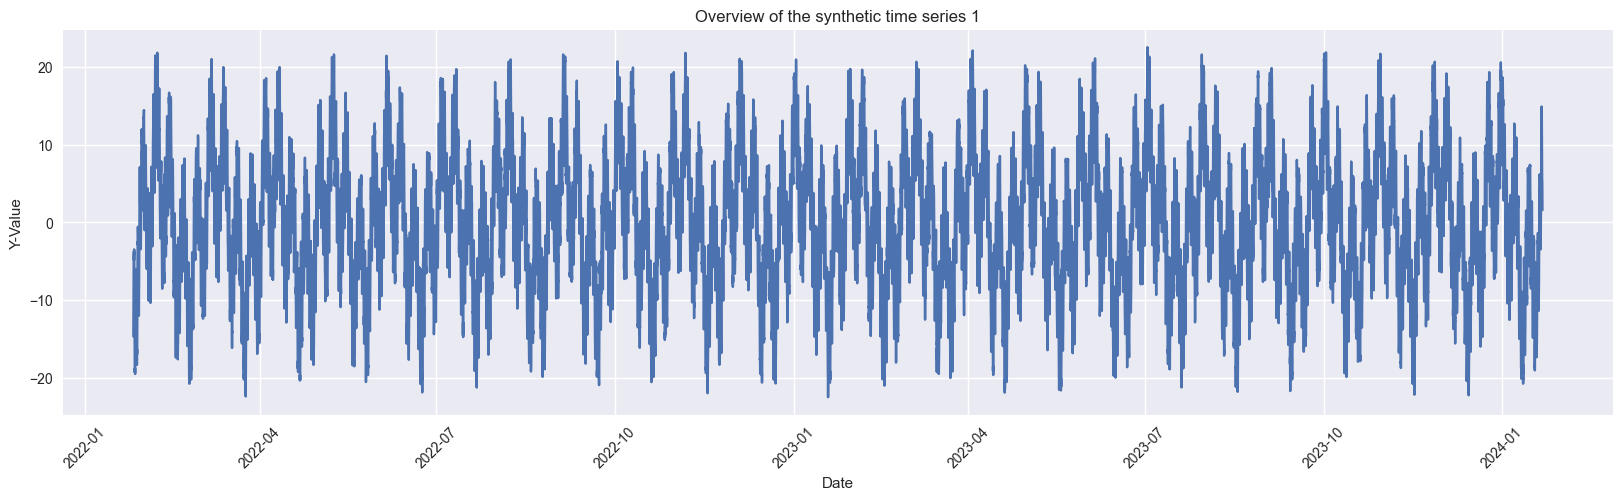

In [6]:
# Plot
plt.figure(figsize=(20, 5))
plt.plot(df1['date'], df1['TARGET'])
plt.title('Overview of the synthetic time series 1')
plt.xlabel('Date')
plt.xticks(rotation = 45)
plt.ylabel('Y-Value')
plt.show()

In [ ]:
df2.head()

,date,TARGET
0,2022-01-04 20:00:00,-2.771159
1,2022-01-04 21:00:00,-3.925664
2,2022-01-04 22:00:00,-3.202413
3,2022-01-04 23:00:00,-0.233802
4,2022-01-05 00:00:00,0.627382


In [ ]:
# Descriptive statistics
df2.describe()

,TARGET
count,17420.000000
mean,0.086133
std,9.459860
min,-24.797278
25%,-6.713751
50%,0.120974
75%,6.854593
max,24.699640


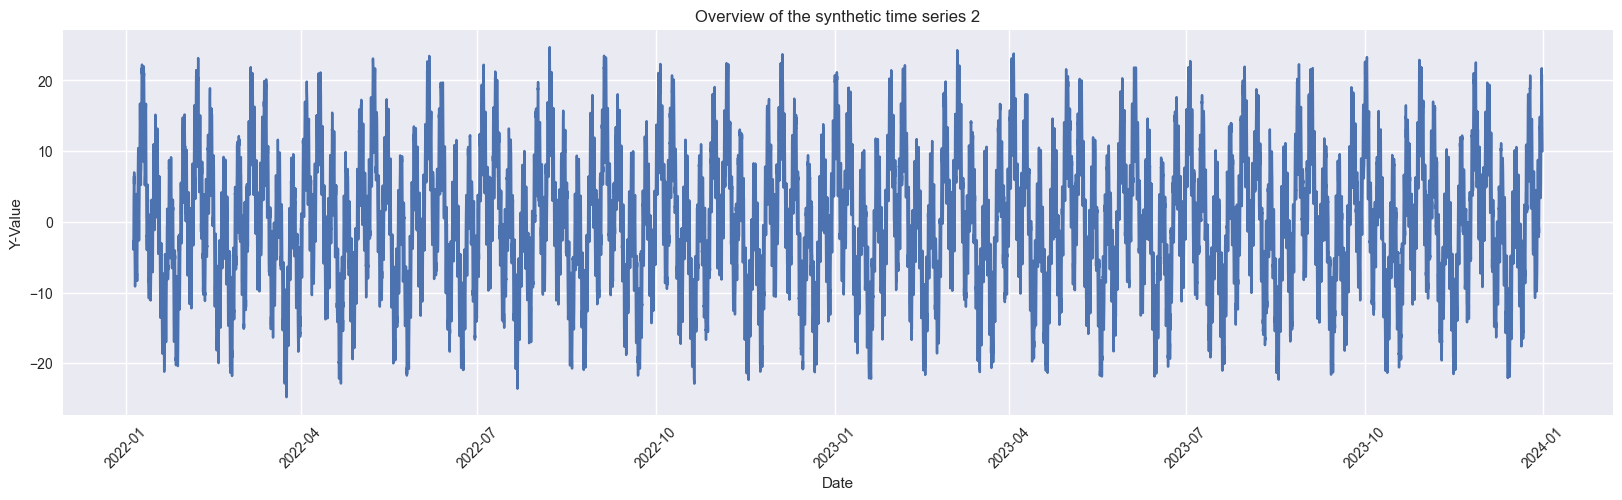

In [7]:
# Plot
plt.figure(figsize=(20, 5))
plt.plot(df2['date'], df2['TARGET'])
plt.title('Overview of the synthetic time series 2')
plt.xlabel('Date')
plt.ylabel('Y-Value')
plt.xticks(rotation = 45)
plt.show()

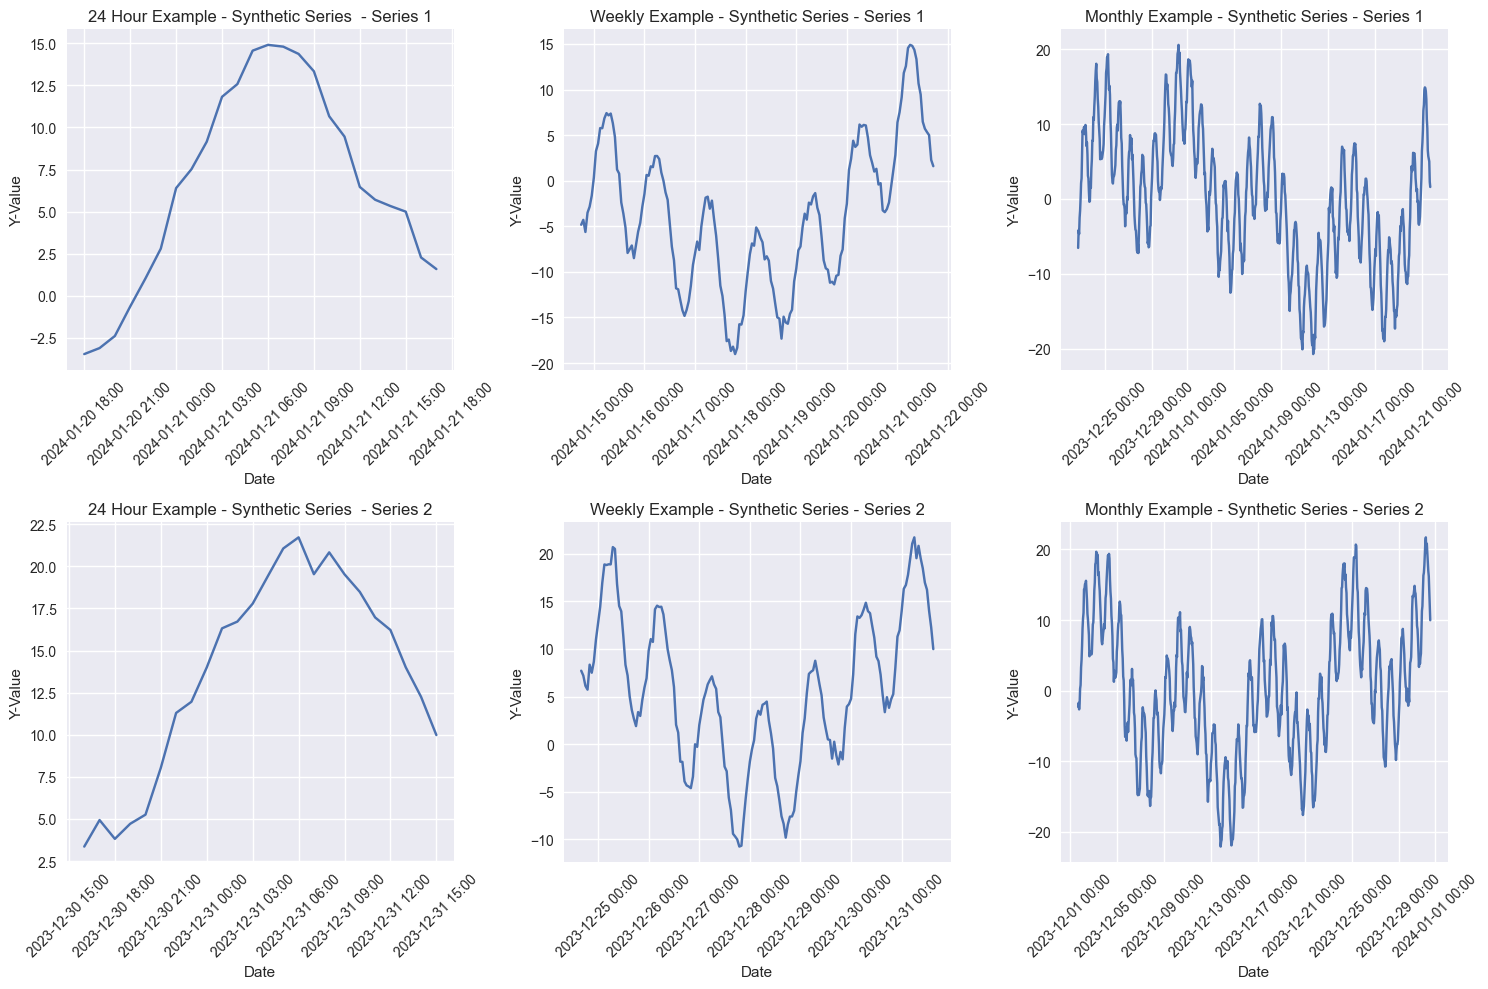

In [9]:
import matplotlib.dates as mdates

title_list = ["24 Hour Example - Synthetic Series ","Weekly Example - Synthetic Series", "Monthly Example - Synthetic Series"]
title_list_series1 = [title + " - Series 1" for title in title_list]
title_list_series2 = [title + " - Series 2" for title in title_list]
hour_list = [24, 168, 720]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
for i, ax in enumerate(axes.flatten()):
    df = df1 if i < 3 else df2
    item = i if i < 3 else i - 3
    title_list = title_list_series1 if i < 3 else title_list_series2

    ax.plot(pd.to_datetime(df['date'][-hour_list[item]:]), df['TARGET'][-hour_list[item]:])
    ax.set_title(title_list[item])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    ax.set_xlabel('Date')
    #ax.set_xticks(xticks[item])
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel('Y-Value')

plt.tight_layout()
plt.show()

### **3.2) 30 Years of European Wind Generation**

This dataset contains hourly estimates of an area's energy potential for 1986-2015 as a percentage of a power plant's maximum output.
The data is available at both the national level with and the NUTS 2 level. The NUTS 2 system divides the EU into 276 statistical units. The national level data contains observations from 29 european countries, such as United Kingdom,Germany,Spain.
For the purpose of this prototype, we chose Germany data as a univariate data input for our models

In [10]:
df3 = pd.read_csv('WINDataset/DEWINDh_small.csv')
df3.head()

,date,TARGET
0,2014-01-05 04:00:00,1.000000e-10
1,2014-01-05 05:00:00,1.000000e-10
2,2014-01-05 06:00:00,1.000000e-10
3,2014-01-05 07:00:00,1.000000e-10
4,2014-01-05 08:00:00,3.851301e-02


In [11]:
# Descriptive statistics
df3.describe()

,TARGET
count,1.742000e+04
mean,1.009882e-01
std,1.531910e-01
min,1.000000e-10
25%,1.000000e-10
50%,2.592006e-03
75%,1.617573e-01
max,6.647579e-01


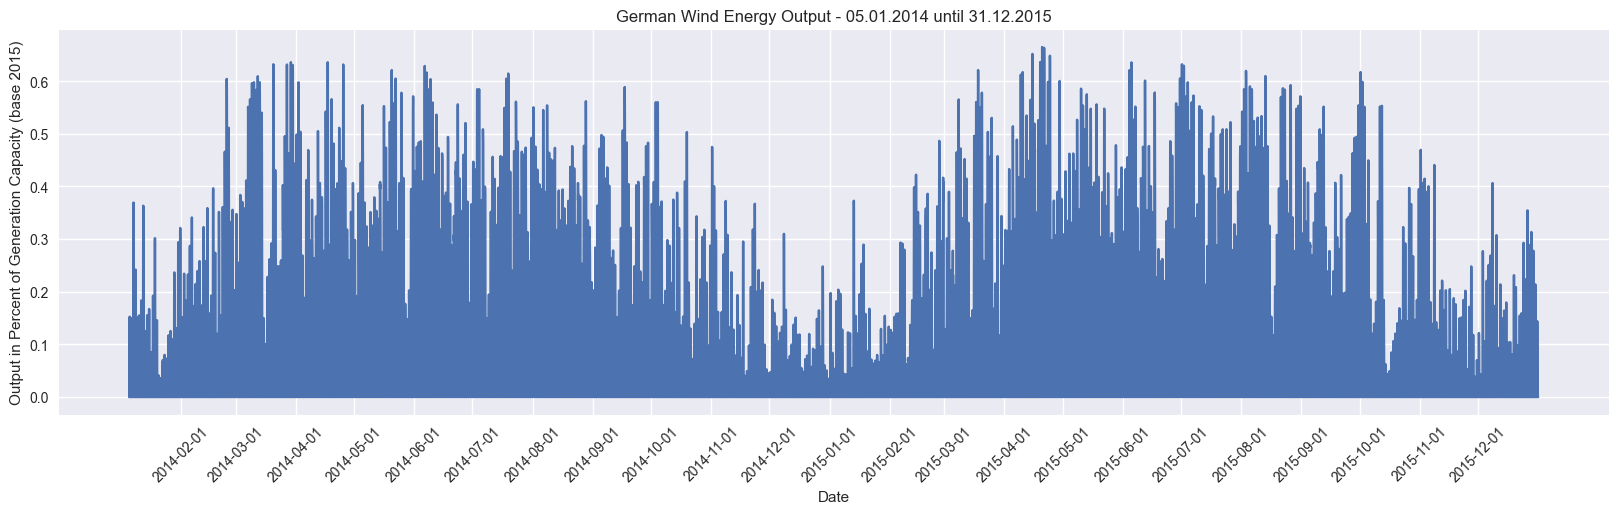

In [12]:
# Plot
plt.figure(figsize=(20, 5))
plt.plot(pd.date_range(start="2014-01-05 4:00:00", end="2015-12-31 23:00:00", freq='H'), df3['TARGET'])
plt.title('German Wind Energy Output - 05.01.2014 until 31.12.2015')
plt.xticks(pd.date_range(start="2014-01-05", end="2015-12-31", freq='MS'))
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Output in Percent of Generation Capacity (base 2015)')
plt.show()

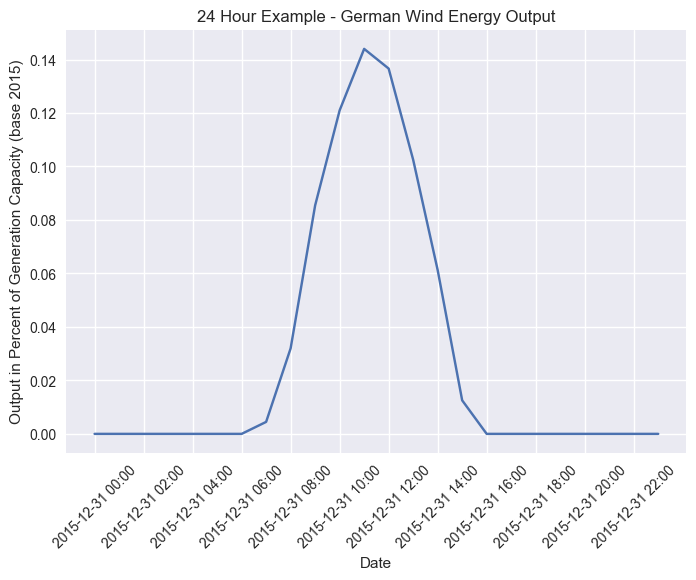

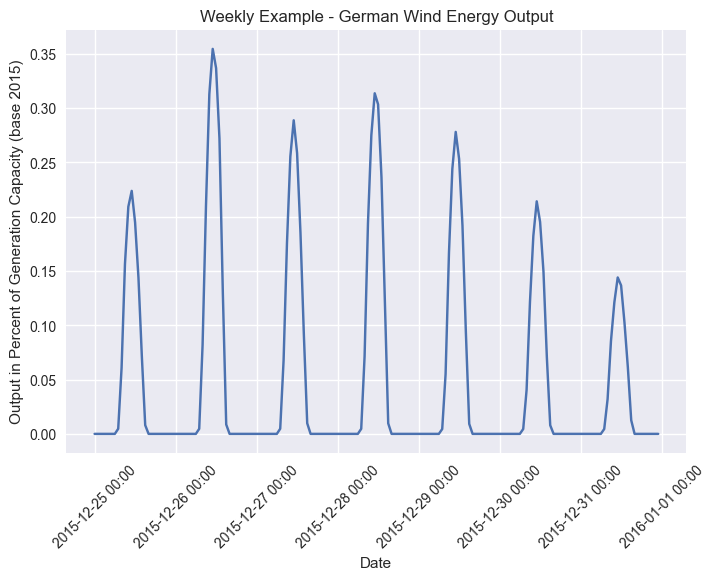

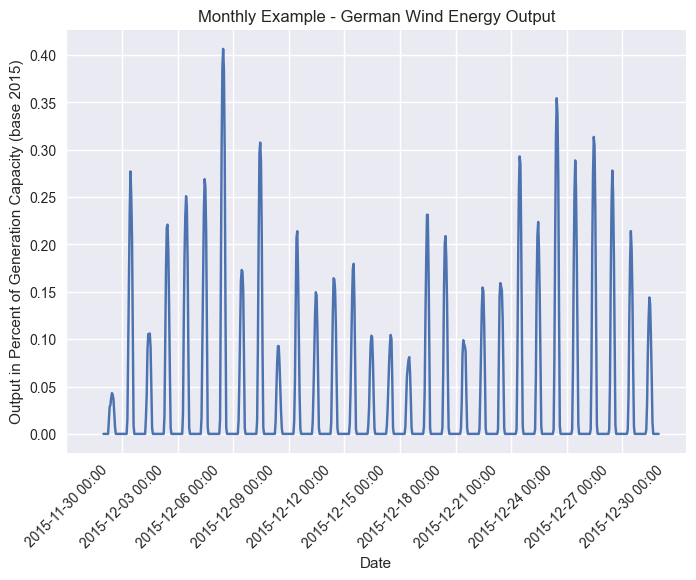

In [13]:
import matplotlib.dates as mdates

hour_list = [24, 168, 720]
title_list = ["24 Hour Example - German Wind Energy Output","Weekly Example - German Wind Energy Output", "Monthly Example - German Wind Energy Output"]
xticks = [pd.date_range(start="2015-12-31 00:00:00", end="2015-12-31 23:00:00", freq='2H'),pd.date_range(start="2015-12-25 00:00:00", end="2016-01-01 00:00:00", freq='D'),pd.date_range(start="2015-11-30 00:00:00", end="2015-12-31 23:00:00", freq='3D')]


for item in range(0,3):
    plt.plot(pd.to_datetime(df3['date'][-hour_list[item]:]), df3['TARGET'][-hour_list[item]:])
    plt.title(title_list[item])
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.xlabel('Date')
    plt.xticks(xticks[item])
    plt.xticks(rotation=45)
    plt.ylabel('Output in Percent of Generation Capacity (base 2015)')    
    plt.show()

To better see the small scale differences between the two datasets we present three graphs of each dataset displaying a day, a week and a month.

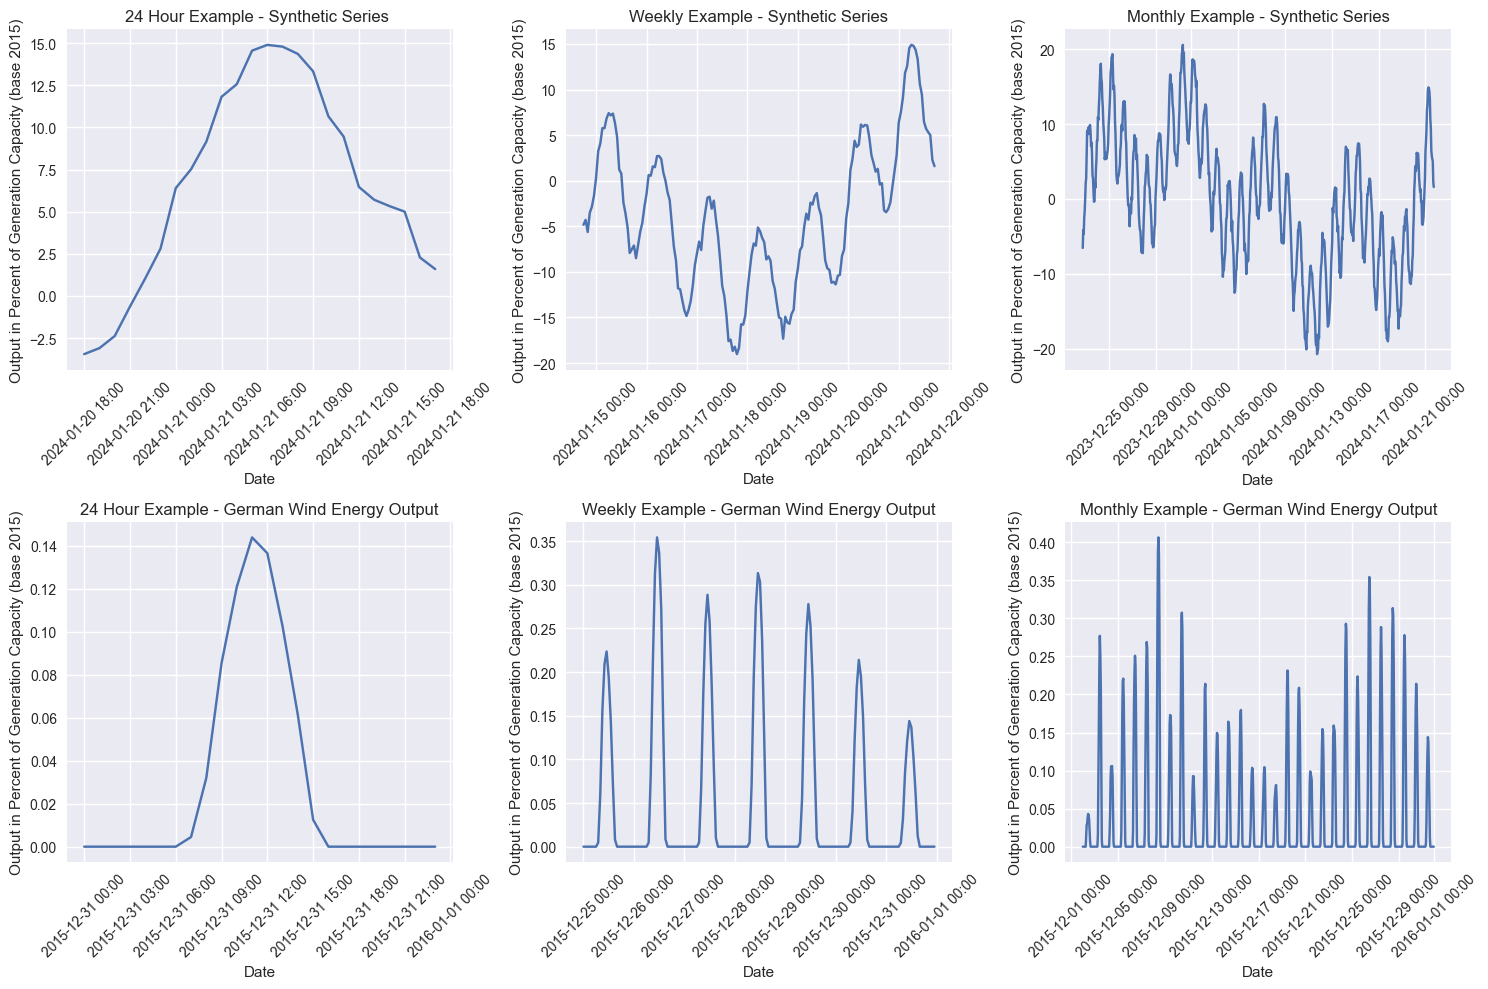

In [14]:
title_list_synth = ["24 Hour Example - Synthetic Series ","Weekly Example - Synthetic Series", "Monthly Example - Synthetic Series"]
title_list_energy = ["24 Hour Example - German Wind Energy Output","Weekly Example - German Wind Energy Output", "Monthly Example - German Wind Energy Output"]
#xticks = [pd.date_range(start="2023-12-31 00:00:00", end="2023-12-31 23:00:00", freq='2H'),pd.date_range(start="2023-12-25 00:00:00", end="2024-01-01 00:00:00", freq='D'),pd.date_range(start="2023-11-30 00:00:00", end="2023-12-31 23:00:00", freq='3D')]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
for i, ax in enumerate(axes.flatten()):
    df = df1 if i < 3 else df3
    item = i if i < 3 else i - 3
    title_list = title_list_synth if i < 3 else title_list_energy

    ax.plot(pd.to_datetime(df['date'][-hour_list[item]:]), df['TARGET'][-hour_list[item]:])
    ax.set_title(title_list[item])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    ax.set_xlabel('Date')
    #ax.set_xticks(xticks[item])
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel('Output in Percent of Generation Capacity (base 2015)')

plt.tight_layout()
plt.show()

## **4. Forecasting Results**

### **4.1) Synthetic Data**

Predictions and true values are numpy arrays of shape `number_of_windows, number_of_observations, number_of_targets` which in case of both synthetic and wind data will be (2848, 24, 1). 

Metrics is an `np.array([mae, mse, rmse, mape, mspe]`



First we load the saved result of our synthetic dataset from our trained models. As mentioned before, each model has 3 results for 3 prediction lengths - 24H,168H and 720H.

In [46]:
# Load Informer Results for 24-Hour Synthetic Data
informer_synthpreds_24 = np.load('results/informerstack_SYNTHh1_ftS_sl96_ll48_pl24_dm512_nh8_el[3, 2, 1]_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0/pred.npy')
informer_synthtrue_24 = np.load('results/informerstack_SYNTHh1_ftS_sl96_ll48_pl24_dm512_nh8_el[3, 2, 1]_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0/true.npy')
informer_synthmetrics_24 = np.load('results/informerstack_SYNTHh1_ftS_sl96_ll48_pl24_dm512_nh8_el[3, 2, 1]_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0/metrics.npy')

# Load Autoformer Results for 24-Hour Synthetic Data
autoformer_synthpreds_24 = np.load('results/Synth1_96_24_Autoformer_Synth1_ftS_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/pred.npy')
autoformer_synthtrue_24 = np.load('results/Synth1_96_24_Autoformer_Synth1_ftS_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/true.npy')
autoformer_synthmetrics_24 = np.load('results/Synth1_96_24_Autoformer_Synth1_ftS_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/metrics.npy')

# Load Pyraformer Results for 24-Hour Synthetic Data
pyraformer_synthpreds_24 = np.load('Pyraformer/data/synthetic/predictions_synthetic_24_0.npy')
pyraformer_synthtrue_24 = np.load('Pyraformer/data/synthetic/trues_synthetic_24_0.npy')
pyraformer_synthmetrics_24 = np.load('Pyraformer/results/syntheticmetricssynthetic24.npy')

# Load Informer Results for 168-Hour Synthetic Data
informer_synthpreds_168 = np.load('results/informerstack_SYNTHh1_ftS_sl96_ll48_pl168_dm512_nh8_el[3, 2, 1]_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0/pred.npy')
informer_synthtrue_168 = np.load('results/informerstack_SYNTHh1_ftS_sl96_ll48_pl168_dm512_nh8_el[3, 2, 1]_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0/true.npy')
informer_synthmetrics_168 = np.load('results/informerstack_SYNTHh1_ftS_sl96_ll48_pl168_dm512_nh8_el[3, 2, 1]_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0/metrics.npy')

# Load Autoformer Results for 168-Hour Synthetic Data
autoformer_synthpreds_168 = np.load('results/Synth1_96_168_Autoformer_Synth1_ftS_sl96_ll48_pl168_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/pred.npy')
autoformer_synthtrue_168 = np.load('results/Synth1_96_168_Autoformer_Synth1_ftS_sl96_ll48_pl168_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/true.npy')
autoformer_synthmetrics_168 = np.load('results/Synth1_96_168_Autoformer_Synth1_ftS_sl96_ll48_pl168_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/metrics.npy')

# Load Pyraformer Results for 168-Hour Synthetic Data
pyraformer_synthpreds_168 = np.load('Pyraformer/data/synthetic/predictions_synthetic_168_0.npy')
pyraformer_synthtrue_168 = np.load('Pyraformer/data/synthetic/trues_synthetic_168_0.npy')
pyraformer_synthmetrics_168 = np.load('Pyraformer/results/syntheticmetricssynthetic168.npy')
# Load Informer Results for 720-Hour Synthetic Data
informer_synthpreds_720 = np.load('results/informerstack_SYNTHh1_ftS_sl96_ll48_pl720_dm512_nh8_el[3, 2, 1]_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0/pred.npy')
informer_synthtrue_720 = np.load('results/informerstack_SYNTHh1_ftS_sl96_ll48_pl720_dm512_nh8_el[3, 2, 1]_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0/true.npy')
informer_synthmetrics_720 = np.load('results/informerstack_SYNTHh1_ftS_sl96_ll48_pl720_dm512_nh8_el[3, 2, 1]_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0/metrics.npy')

# Load Autoformer Results for 720-Hour Synthetic Data
autoformer_synthpreds_720 = np.load('results/Synth1_96_720_Autoformer_Synth1_ftS_sl96_ll48_pl720_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/pred.npy')
autoformer_synthtrue_720 = np.load('results/Synth1_96_720_Autoformer_Synth1_ftS_sl96_ll48_pl720_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/true.npy')
autoformer_synthmetrics_720 = np.load('results/Synth1_96_720_Autoformer_Synth1_ftS_sl96_ll48_pl720_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/metrics.npy')

# Load Pyraformer Results for 720-Hour Synthetic Data
pyraformer_synthpreds_720 = np.load('Pyraformer/data/synthetic/predictions_synthetic_720_0.npy')
pyraformer_synthtrue_720 = np.load('Pyraformer/data/synthetic/trues_synthetic_720_0.npy')
pyraformer_synthmetrics_720 = np.load('Pyraformer/results/syntheticmetricssynthetic720.npy')

#### **4.1.1) 24-Hour Windows (Day)**

Below we compute $\text{MSE}$ scores per each 24-hour prediction window for forecasts of each model on our **synthetic** dataset.

In [64]:
informer_errors_synth_24 = np.array([MSE(informer_synthpreds_24[i, :, :], informer_synthtrue_24 [i, :, :]) for i in range(len(informer_synthpreds_24))])
autoformer_errors_synth_24 = np.array([MSE(autoformer_synthpreds_24[i, :, :], autoformer_synthtrue_24[i, :, :]) for i in range(len(autoformer_synthpreds_24))])
pyraformer_errors_synth_24 = np.array([MSE(pyraformer_synthpreds_24[i, :, :], pyraformer_synthtrue_24[i, :, :]) for i in range(len(pyraformer_synthpreds_24))])

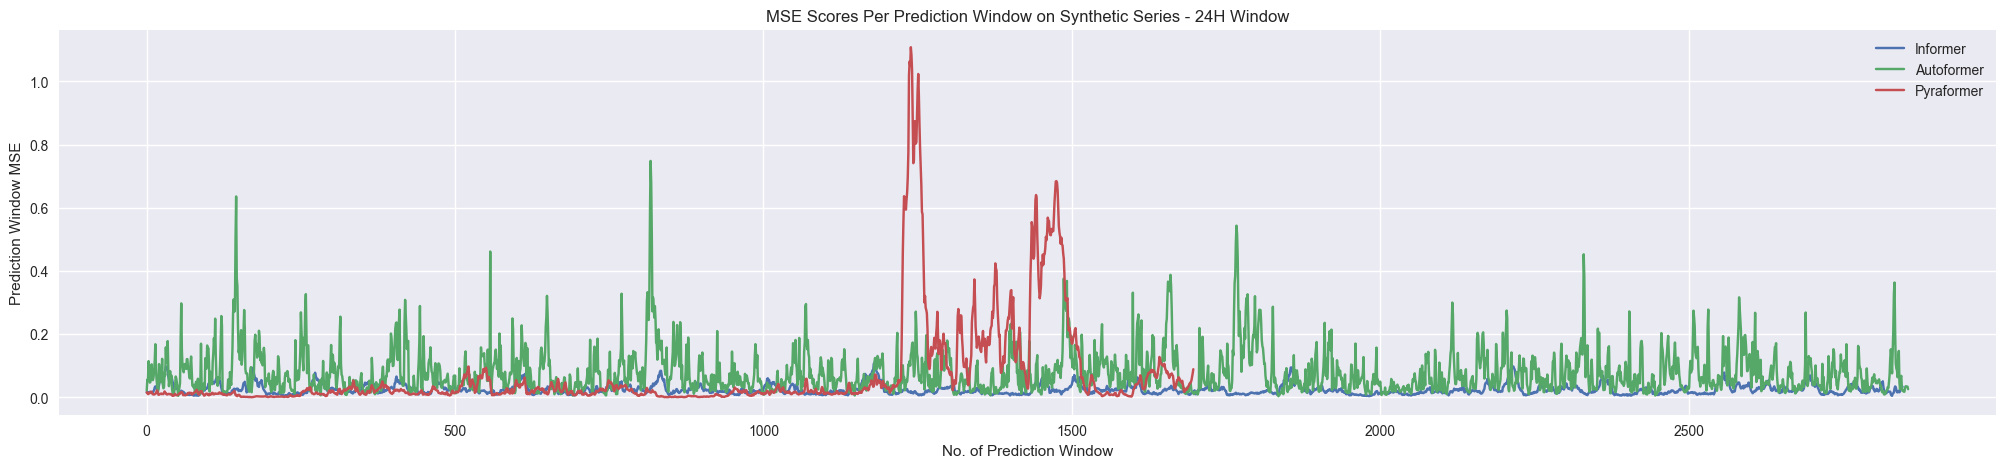

In [65]:
plt.figure(figsize=(25, 5))
plt.plot(informer_errors_synth_24, label='Informer')
plt.plot(autoformer_errors_synth_24, label='Autoformer')
plt.plot(pyraformer_errors_synth_24, label='Pyraformer')
plt.title('MSE Scores Per Prediction Window on Synthetic Series - 24H Window')
plt.xlabel('No. of Prediction Window')
plt.ylabel('Prediction Window MSE')
plt.legend()
plt.show()
plt.close()

#### **4.1.2) 168-Hour Windows (Week)**

Next we compute $\text{MSE}$ scores per each 168-hour prediction window for forecasts of each model on our **synthetic** dataset.

In [49]:
informer_errors_synth_168 = np.array([MSE(informer_synthpreds_168[i, :, :], informer_synthtrue_168[i, :, :]) for i in range(len(informer_synthpreds_168))])
autoformer_errors_synth_168 = np.array([MSE(autoformer_synthpreds_168[i, :, :],autoformer_synthtrue_168[i, :, :]) for i in range(len(autoformer_synthpreds_168))])
pyraformer_errors_synth_168 = np.array([MSE(pyraformer_synthpreds_168[i, :, :],pyraformer_synthtrue_168[i, :, :]) for i in range(len(pyraformer_synthpreds_168))])

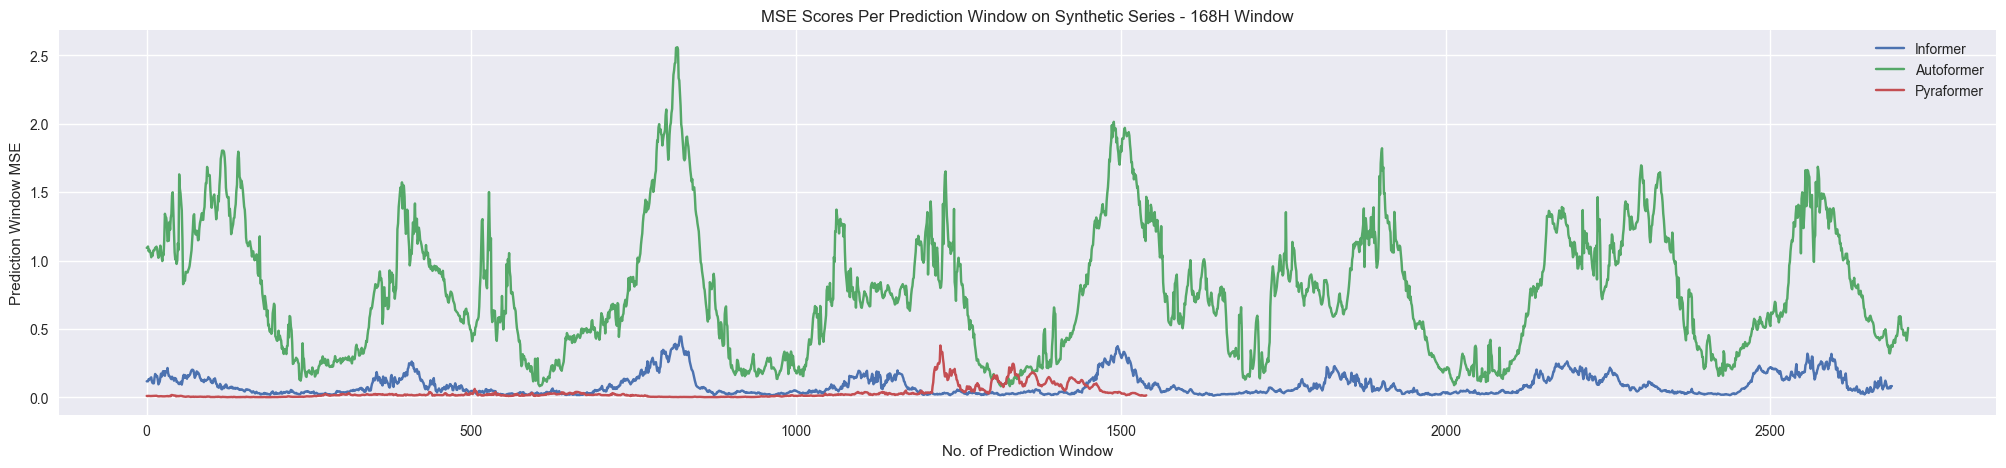

In [50]:
plt.figure(figsize=(25, 5))
plt.plot(informer_errors_synth_168, label='Informer')
plt.plot(autoformer_errors_synth_168, label='Autoformer')
plt.plot(pyraformer_errors_synth_168, label='Pyraformer')
plt.title('MSE Scores Per Prediction Window on Synthetic Series - 168H Window')
plt.xlabel('No. of Prediction Window')
plt.ylabel('Prediction Window MSE')
plt.legend()
plt.show()
plt.close()

#### **4.1.3) 720-Hour Windows (Month)**

Last, we compute $\text{MSE}$ scores per each 720-hour prediction window for forecasts of each model on our **synthetic** dataset.

In [51]:
informer_errors_synth_720 = np.array([MSE(informer_synthpreds_720[i, :, :], informer_synthtrue_720[i, :, :]) for i in range(len(informer_synthpreds_720))])
autoformer_errors_synth_720 = np.array([MSE(autoformer_synthpreds_720[i, :, :], autoformer_synthtrue_720[i, :, :]) for i in range(len(autoformer_synthpreds_720))])
pyraformer_errors_synth_720 = np.array([MSE(pyraformer_synthpreds_720[i, :, :], pyraformer_synthtrue_720[i, :, :]) for i in range(len(pyraformer_synthpreds_720))])

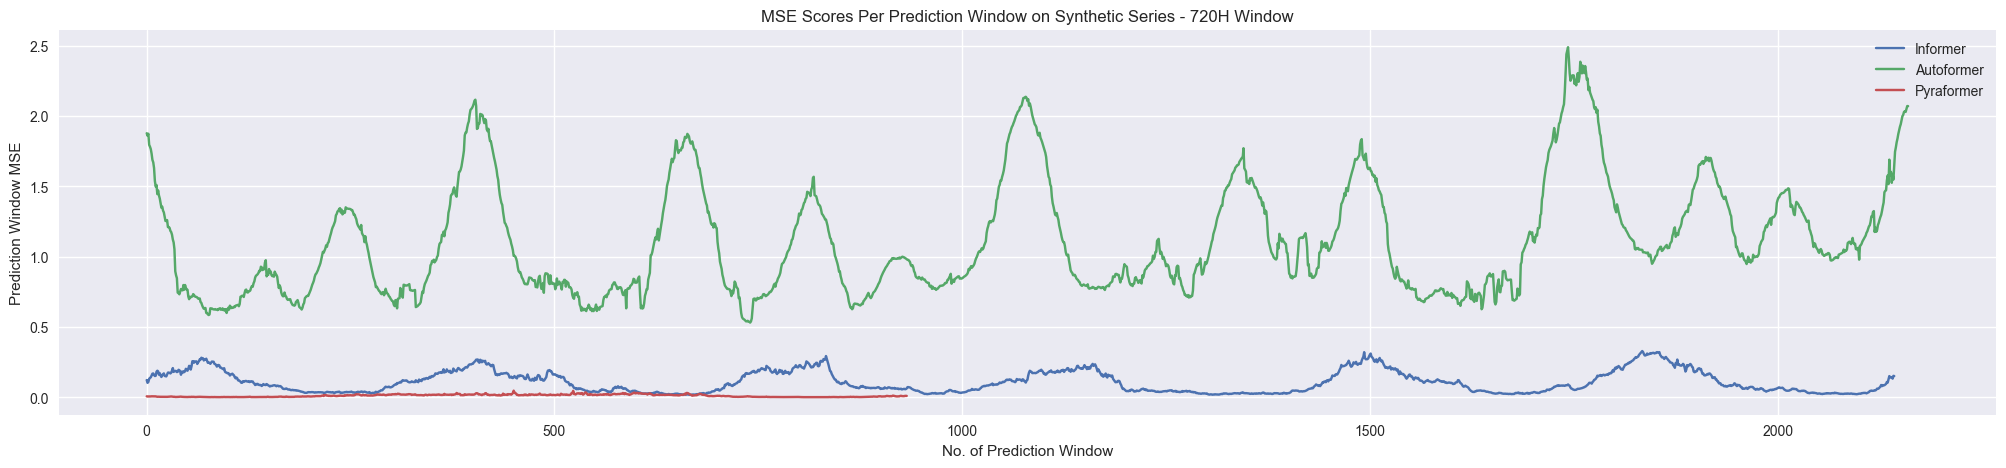

In [52]:
plt.figure(figsize=(25, 5))
plt.plot(informer_errors_synth_720, label='Informer')
plt.plot(autoformer_errors_synth_720, label='Autoformer')
plt.plot(pyraformer_errors_synth_720, label='Pyraformer')
plt.title('MSE Scores Per Prediction Window on Synthetic Series - 720H Window')
plt.xlabel('No. of Prediction Window')
plt.ylabel('Prediction Window MSE')
plt.legend()
plt.show()
plt.close()

Brief conclusion of the comparison of the 3 models goes here

### **4.2) Wind Data**

Now we load the saved result of our wibd dataset from our trained models. The dimensions of the predictions and true values are the same as the ones of the synthetic data.

In [53]:
# Load Informer Results for 24-hour Wind Data
informer_windpreds_24 = np.load('results/informerstack_DEWINDh_small_ftS_sl96_ll48_pl24_dm512_nh8_el[3, 2, 1]_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0/pred.npy')
informer_windtrue_24 = np.load('results/informerstack_SYNTHh1_ftS_sl96_ll48_pl24_dm512_nh8_el[3, 2, 1]_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0/true.npy')
informer_windmetrics_24 = np.load('results/informerstack_DEWINDh_small_ftS_sl96_ll48_pl24_dm512_nh8_el[3, 2, 1]_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0/metrics.npy')

# Load Autoformer Results for 24-hour Wind Data
autoformer_windpreds_24 = np.load('results/Windh1_96_24_Autoformer_Windh1_ftS_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/pred.npy')
autoformer_windtrue_24 = np.load('results/Windh1_96_24_Autoformer_Windh1_ftS_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/true.npy')
autoformer_windmetrics_24 = np.load('results/Windh1_96_24_Autoformer_Windh1_ftS_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/metrics.npy')

# Load Pyraformer Results for 24-hour Wind Data
pyraformer_windpreds_24 = np.load('Pyraformer/data/wind/predictions_wind_24_2.npy')
pyraformer_windtrue_24 = np.load('Pyraformer/data/wind/trues_wind_24_2.npy')
pyraformer_windmetrics_24 = np.load('Pyraformer/results/windmetricswind24.npy')

# Load Informer Results for 168-hour Wind Data
informer_windpreds_168 = np.load('results/informerstack_DEWINDh_small_ftS_sl96_ll48_pl168_dm512_nh8_el[3, 2, 1]_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0/pred.npy')
informer_windtrue_168 = np.load('results/informerstack_DEWINDh_small_ftS_sl96_ll48_pl168_dm512_nh8_el[3, 2, 1]_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0/true.npy')
informer_windmetrics_168 = np.load('results/informerstack_DEWINDh_small_ftS_sl96_ll48_pl168_dm512_nh8_el[3, 2, 1]_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0/metrics.npy')

# Load Autoformer Results for 168-hour Wind Data
autoformer_windpreds_168 = np.load('results/Windh1_96_168_Autoformer_Windh1_ftS_sl96_ll48_pl168_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/pred.npy')
autoformer_windtrue_168 = np.load('results/Windh1_96_168_Autoformer_Windh1_ftS_sl96_ll48_pl168_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/true.npy')
autoformer_windmetrics_168 = np.load('results/Windh1_96_168_Autoformer_Windh1_ftS_sl96_ll48_pl168_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/metrics.npy')

# Load Pyraformer Results for 168-hour Wind Data
pyraformer_windpreds_168 = np.load('Pyraformer/data/wind/predictions_wind_168_4.npy')
pyraformer_windtrue_168 = np.load('Pyraformer/data/wind/trues_wind_168_4.npy')
pyraformer_windmetrics_168 = np.load('Pyraformer/results/windmetricswind168.npy')

# Load Informer Results for 720-hour Wind Data
informer_windpreds_720 = np.load('results/informerstack_DEWINDh_small_ftS_sl96_ll48_pl720_dm512_nh8_el[3, 2, 1]_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0/pred.npy')
informer_windtrue_720 = np.load('results/informerstack_DEWINDh_small_ftS_sl96_ll48_pl720_dm512_nh8_el[3, 2, 1]_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0/true.npy')
informer_windmetrics_720 = np.load('results/informerstack_DEWINDh_small_ftS_sl96_ll48_pl720_dm512_nh8_el[3, 2, 1]_dl2_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0/metrics.npy')

# Load Autoformer Results for 720-hour Wind Data
autoformer_windpreds_720 = np.load('results/Windh1_96_720_Autoformer_Windh1_ftS_sl96_ll48_pl720_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/pred.npy')
autoformer_windtrue_720 = np.load('results/Windh1_96_720_Autoformer_Windh1_ftS_sl96_ll48_pl720_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/true.npy')
autoformer_windmetrics_720 = np.load('results/Windh1_96_720_Autoformer_Windh1_ftS_sl96_ll48_pl720_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/metrics.npy')

# Load Pyraformer Results for 720-hour Wind Data
pyraformer_windpreds_720 = np.load('Pyraformer/data/wind/predictions_wind_720_0.npy')
pyraformer_windtrue_720 = np.load('Pyraformer/data/wind/trues_wind_720_0.npy')
pyraformer_windmetrics_720 = np.load('Pyraformer/results/windmetricswind720.npy')

#### **4.2.1) 24-Hour Windows (Day)**

Below we compute $\text{MSE}$ scores per each 24-hour prediction window for forecasts of each model on our **wind** dataset.

In [54]:
informer_errors_wind_24 = np.array([MSE(informer_windpreds_24[i, :, :], informer_windtrue_24[i, :, :]) for i in range(len(informer_windpreds_24))])
autoformer_errors_wind_24 = np.array([MSE(autoformer_windpreds_24[i, :, :], autoformer_windtrue_24[i, :, :]) for i in range(len(autoformer_windpreds_24))])
pyraformer_errors_wind_24 = np.array([MSE(pyraformer_windpreds_24[i, :, :], pyraformer_windtrue_24[i, :, :]) for i in range(len(pyraformer_windpreds_24))])

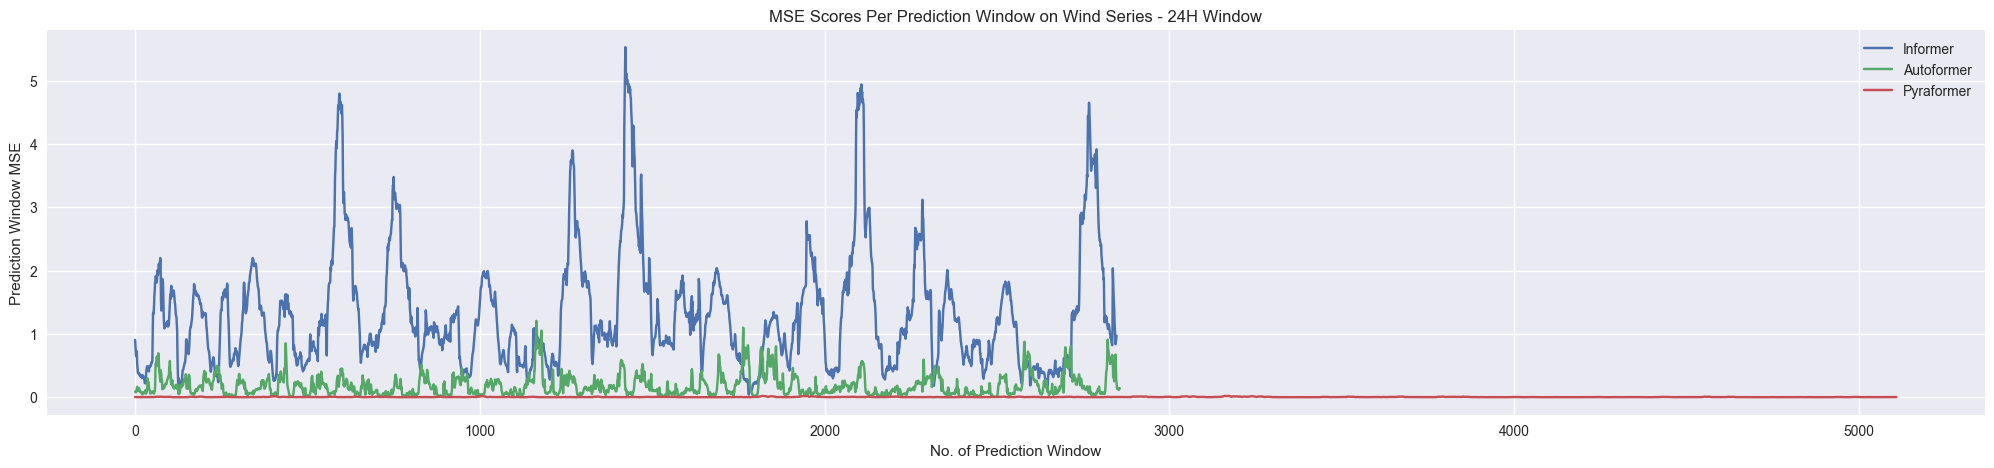

In [55]:
plt.figure(figsize=(25, 5))
plt.plot(informer_errors_wind_24, label='Informer')
plt.plot(autoformer_errors_wind_24, label='Autoformer')
plt.plot(pyraformer_errors_wind_24, label='Pyraformer')
plt.title('MSE Scores Per Prediction Window on Wind Series - 24H Window')
plt.xlabel('No. of Prediction Window')
plt.ylabel('Prediction Window MSE')
plt.legend()
plt.show()
plt.close()

#### **4.2.2) 168-Hour Windows (Week)**

Next we compute $\text{MSE}$ scores per each 168-hour prediction window for forecasts of each model on our **wind** dataset.

In [56]:
informer_errors_wind_168 = np.array([MSE(informer_windpreds_168[i, :, :], informer_windtrue_168[i, :, :]) for i in range(len(informer_windpreds_168))])
autoformer_errors_wind_168 = np.array([MSE(autoformer_windpreds_168[i, :, :], autoformer_windtrue_168[i, :, :]) for i in range(len(autoformer_windpreds_168))])
pyraformer_errors_wind_168 =np.array([MSE(pyraformer_windpreds_168[i, :, :], pyraformer_windtrue_168[i, :, :]) for i in range(len(pyraformer_windpreds_168))])

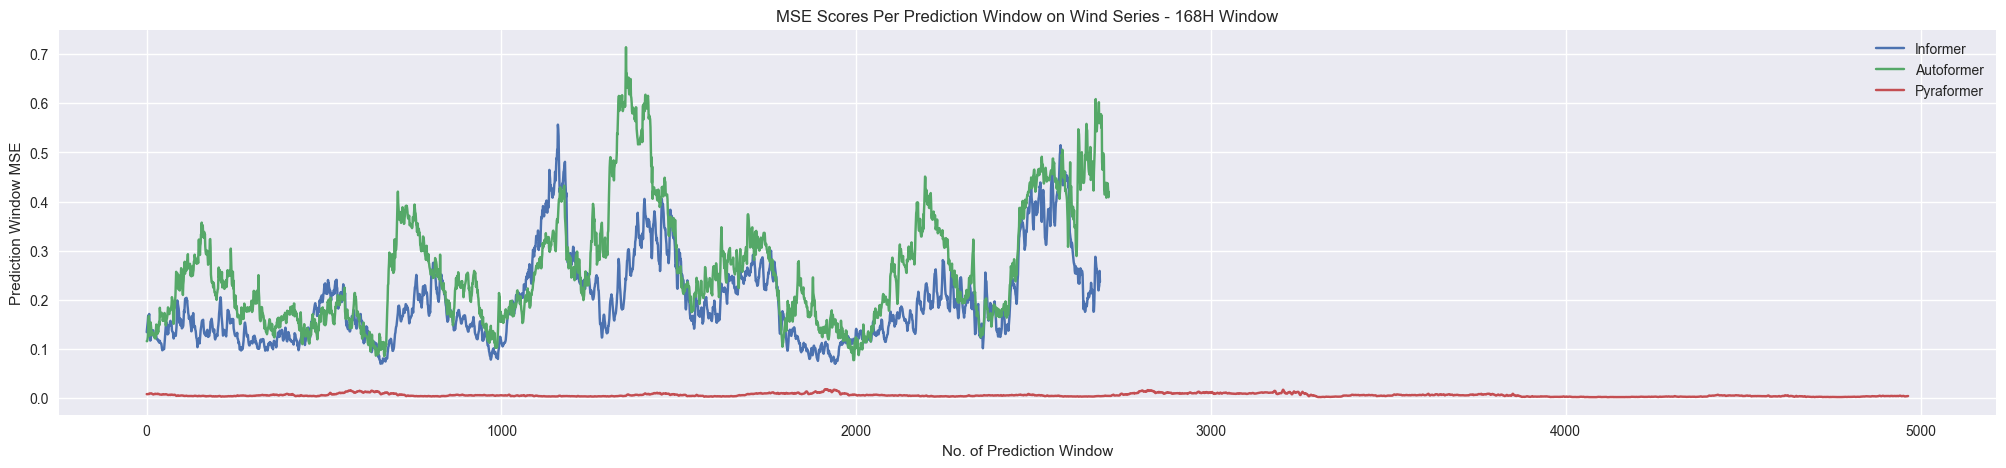

In [57]:
plt.figure(figsize=(25, 5))
plt.plot(informer_errors_wind_168, label='Informer')
plt.plot(autoformer_errors_wind_168, label='Autoformer')
plt.plot(pyraformer_errors_wind_168, label='Pyraformer')
plt.title('MSE Scores Per Prediction Window on Wind Series - 168H Window')
plt.xlabel('No. of Prediction Window')
plt.ylabel('Prediction Window MSE')
plt.legend()
plt.show()
plt.close()

#### **4.2.3) 720-Hour Windows (Month)**

Last, we compute $\text{MSE}$ scores per each 720-hour prediction window for forecasts of each model on our **wind** dataset.

In [58]:
informer_errors_wind_720 = np.array([MSE(informer_windpreds_720[i, :, :], informer_windtrue_720[i, :, :]) for i in range(len(informer_windpreds_720))])
autoformer_errors_wind_720 = np.array([MSE(autoformer_windpreds_720[i, :, :], autoformer_windtrue_720[i, :, :]) for i in range(len(autoformer_windpreds_720))])
pyraformer_errors_wind_720 = np.array([MSE(pyraformer_windpreds_720[i, :, :], pyraformer_windtrue_720[i, :, :]) for i in range(len(pyraformer_windpreds_720))])

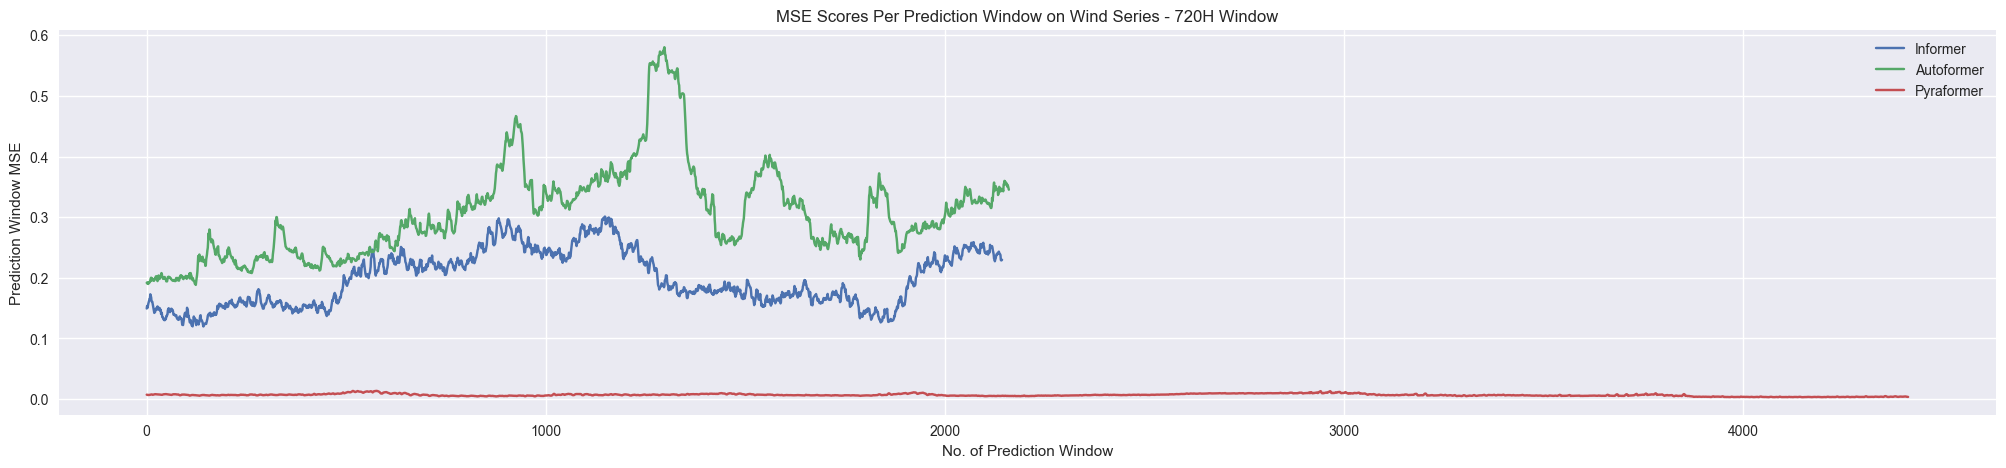

In [59]:
plt.figure(figsize=(25, 5))
plt.plot(informer_errors_wind_720, label='Informer')
plt.plot(autoformer_errors_wind_720, label='Autoformer')
plt.plot(pyraformer_errors_wind_720, label='Pyraformer')
plt.title('MSE Scores Per Prediction Window on Wind Series - 720H Window')
plt.xlabel('No. of Prediction Window')
plt.ylabel('Prediction Window MSE')
plt.legend()
plt.show()
plt.close()

## **5. Summary**

In [60]:
errors_synthetic_informer = [informer_synthmetrics_24[1], informer_synthmetrics_168[1], informer_synthmetrics_720[1]]
errors_synthetic_autoformer = [autoformer_synthmetrics_24[1], autoformer_synthmetrics_168[1], autoformer_synthmetrics_720[1]]
errors_synthetic_pyraformer = [pyraformer_synthmetrics_24[0],pyraformer_synthmetrics_168[0],pyraformer_synthmetrics_720[0]]
windows = ['24', '168', '720']

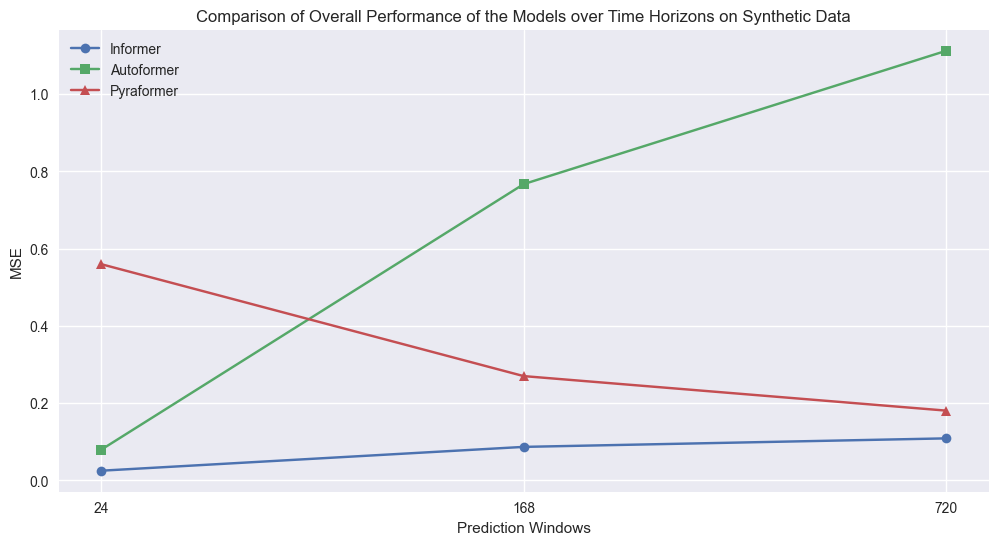

In [61]:
plt.figure(figsize=(12, 6))
plt.plot(windows, errors_synthetic_informer, marker='o', label='Informer')
plt.plot(windows, errors_synthetic_autoformer, marker='s', label='Autoformer')
plt.plot(windows, errors_synthetic_pyraformer, marker='^', label='Pyraformer')
plt.xlabel('Prediction Windows')
plt.ylabel('MSE')
plt.title('Comparison of Overall Performance of the Models over Time Horizons on Synthetic Data')
plt.legend()
plt.show()
plt.close()

In [62]:
errors_wind_informer = [informer_windmetrics_24[1], informer_windmetrics_168[1], informer_windmetrics_720[1]]
errors_wind_autoformer = [autoformer_windmetrics_24[1], autoformer_windmetrics_168[1], autoformer_windmetrics_720[1]]
errors_wind_pyraformer = [pyraformer_windmetrics_24[0], pyraformer_windmetrics_168[0], pyraformer_windmetrics_720[0]]

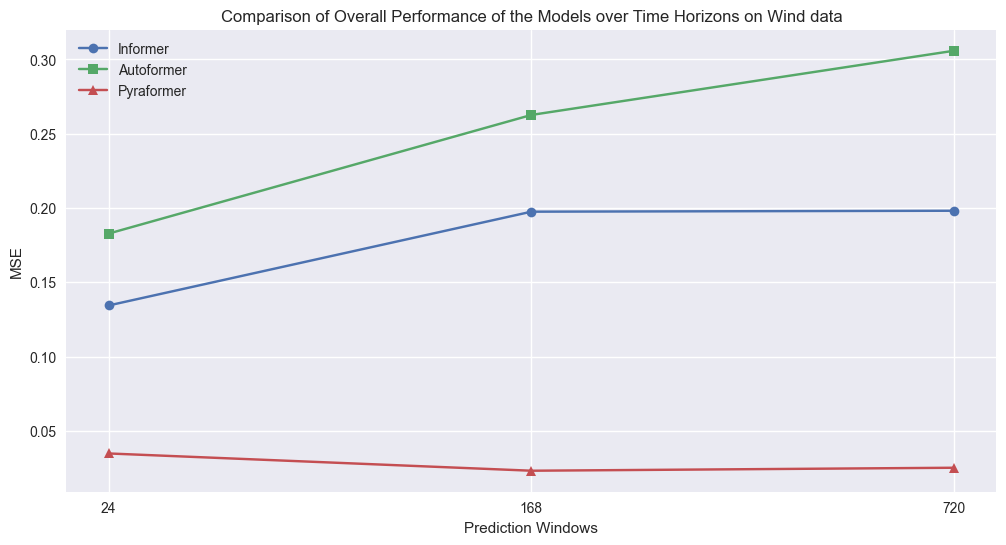

In [63]:
plt.figure(figsize=(12, 6))
plt.plot(windows, errors_wind_informer, marker='o', label='Informer')
plt.plot(windows, errors_wind_autoformer , marker='s', label='Autoformer')
plt.plot(windows, errors_wind_pyraformer, marker='^', label='Pyraformer')
plt.xlabel('Prediction Windows')
plt.ylabel('MSE')
plt.title('Comparison of Overall Performance of the Models over Time Horizons on Wind data')
plt.legend()
plt.show()
plt.close()

For both datasets you can see that the overall MSE increases with the prediction timeframe.

|  | Informer MSE | Informer MAE | Autoformer MSE | Autoformer MAE | Pyraformer MSE | Pyraformer MAE |
|---------|-------------|-------------|-------------|-------------|-------------|-------------|
| **SYNTHh1** 24 | 0.0249| 0.1256 | 0.0651 | 0.2 | 0.5598 | 0.5522 |
| **SYNTHh1** 168 | 0.0866 | 0.2345 | 0.6487 | 0.6629 | 0.2699 | 0.3919 |
| **SYNTHh1** 720 | 0.1087 | 0.2599 |1.0382 |  0.8269 | 0.1804 | 0.3175 |
| **DEWINDh_small** 24 | 0.1344 | 0.2046 | 0.1368 | 0.2273 | 0.034 | 0.1387 |
| **DEWINDh_small** 168 | 0.1975 | 0.2817 | 0.2789 | 0.3699 | 0.023 | 0.1170 |
| **DEWINDh_small** 720 | 0.1981 | 0.2627 | 0.6038 | 0.5934 |0.025 | 0.1223|


## **6. Reproducibility**

One of the key challenges we are working on is coming up with a unified repository / module that will serve as a one-stop-shop to implement the transformer frameoworks we have selected. Much of these frameworks that have been implemented by academic researchers are more focused on running multiple experiments in one go, with scripts. We have observed that this makes it harder for regular users to interact and experiment with the frameworks.

Due to existing time constraints, we had trained all models given their original code. These can be seen in the model training notebooks included in the attached repository. 

However, we have also began work on making a user-friendly interface for the frameworks that will be easier and more intuitive to use for the users, as well as more suitable for Jupyter Notebooks.

Below, we showcase the initial version which allows the viewers of this prototpy to try retraining the Informer and generating its predictions. 

This initial class is called `InformerTS` and it has following three methods:<br>
- `.compile()`
- `.fit()`
- `.predict()`

It can be either imported from `TransformerAPI.py` file in our repository, or generated by copying the entire code given in the markdown code below.

**Option 1: Import**

Copy the line given within this markdown block:

```python
# Import our user-friendly interface for Informer
from TransformerAPI import InformerTS

# Define Data Paths
data_synth = 'SYNTHh1'
data_synth_path = './SYNTHDataset/' 

data_wind = 'DEWINDh_small'
data_wind_path = './WINDataset/'

# Initialize Informer model
informer = InformerTS(model='informerstack')

# Compile Model
# Note that for the time being, only 'mse' can be used.
informer.compile(learning_rate=1e-4,
                 loss='mse',
                 early_stopping_patience=3)


# Fit the model on whichever dataset (we picked synthetic for this case)
# for the time being, pred_len can only be switched to 168 and 720
informer.fit(
    data=data_synth,
    data_root_path=data_synth_path,
    batch_size=32,
    epochs=8,
    pred_len=24
)

# Predict
informer_synthpreds_24 = informer.predict()

# Obtain metrics and true values
informer_synthtrue_24  = informer.trues
informer_synthmetrics_24 = informer.all_metrics
```

In [ ]:
# Copy Here

**Option 2: Run the Entire Module Here**

In case of complications or not-having access to the `TransformerAPI.py`, you can copy the entire lengthy module given below in the markdown block into a code block and run it.

Do note that the code below is enormous. In case of no complications with `TransformerAPI.py`, consider this line as the end of the notebook.

```python
### A single, unified module for all transformer models.
## In progress, currently includes only Informer.
# Refer to class InformerTS at the end of the module for our user-friendly interface for Transformers-based forecasting

# Imports
import time
import math
import pandas as pd
import numpy as np
from math import sqrt
import os
from pandas.tseries import offsets
from pandas.tseries.frequencies import to_offset
from typing import List
import torch
from torch.utils.data import Dataset, DataLoader
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import warnings
warnings.filterwarnings('ignore')

###########################################################################################################################
# Dot dictionary ##########################################################################################################
class dotdict(dict):
    '''
    Simple class to allow storing model arguments in a dot dictionary.
    '''
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

###########################################################################################################################
# Metrics #################################################################################################################
def RSE(pred, true):
    '''
    Calculates relative quared error.
    '''
    return np.sqrt(np.sum((true-pred)**2)) / np.sqrt(np.sum((true-true.mean())**2))

def CORR(pred, true):
    '''
    Calculates correlation coefficient.
    '''
    u = ((true-true.mean(0))*(pred-pred.mean(0))).sum(0) 
    d = np.sqrt(((true-true.mean(0))**2*(pred-pred.mean(0))**2).sum(0))
    return (u/d).mean(-1)

def MAE(pred, true):
    '''
    Calculates mean absolute error.
    '''
    return np.mean(np.abs(pred-true))

def MSE(pred, true):
    '''
    Calculates mean squared error.
    '''
    return np.mean((pred-true)**2)

def RMSE(pred, true):
    '''
    Calculates root mean suared error.
    '''
    return np.sqrt(MSE(pred, true))

def MAPE(pred, true):
    '''
    Calculates mean absolute percentage error.
    '''
    return np.mean(np.abs((pred - true) / true))

def MSPE(pred, true):
    '''
    Calculates mean squared percentage error.
    '''
    return np.mean(np.square((pred - true) / true))

def metric(pred, true):
    '''
    Wraps up metric functions, calculates and returns all.
    '''
    mae = MAE(pred, true)
    mse = MSE(pred, true)
    rmse = RMSE(pred, true)
    mape = MAPE(pred, true)
    mspe = MSPE(pred, true)
    
    return mae,mse,rmse,mape,mspe

###########################################################################################################################
# Masking #################################################################################################################
class ProbMask():
    '''
    Class for probabilistic masking used in the Informer framework instead of vanilla Transformer's triangular masking.
    '''
    def __init__(self, B, H, L, index, scores, device="cpu"):
        _mask = torch.ones(L, scores.shape[-1], dtype=torch.bool).to(device).triu(1)
        _mask_ex = _mask[None, None, :].expand(B, H, L, scores.shape[-1])
        indicator = _mask_ex[torch.arange(B)[:, None, None],
                             torch.arange(H)[None, :, None],
                             index, :].to(device)
        self._mask = indicator.view(scores.shape).to(device)
    
    @property
    def mask(self):
        return self._mask

class TriangularCausalMask():
    '''
    Class for triangular masking used with Vanilla transformers. 
    '''
    def __init__(self, B, L, device="cpu"):
        mask_shape = [B, 1, L, L]
        with torch.no_grad():
            self._mask = torch.triu(torch.ones(mask_shape, dtype=torch.bool), diagonal=1).to(device)

    @property
    def mask(self):
        return self._mask
    
###########################################################################################################################
#  Data loader and dependencies ###########################################################################################  
# Standard scaler #########################################################################################################
class StandardScaler():
    '''
    Straightforward StandardScaler that can handle Pytorch tensors.
    Methods included are '.fit()', '.transform()', '.inverse_transform().'
    '''
    def __init__(self):
        self.mean = 0.
        self.std = 1.
    
    def fit(self, data):
        self.mean = data.mean(0)
        self.std = data.std(0)

    def transform(self, data):
        mean = torch.from_numpy(self.mean).type_as(data).to(data.device) if torch.is_tensor(data) else self.mean
        std = torch.from_numpy(self.std).type_as(data).to(data.device) if torch.is_tensor(data) else self.std
        return (data - mean) / std

    def inverse_transform(self, data):
        mean = torch.from_numpy(self.mean).type_as(data).to(data.device) if torch.is_tensor(data) else self.mean
        std = torch.from_numpy(self.std).type_as(data).to(data.device) if torch.is_tensor(data) else self.std
        if data.shape[-1] != mean.shape[-1]:
            mean = mean[-1:]
            std = std[-1:]
        return (data * std) + mean
###########################################################################################################################
# Time Features #############################################################################################################
class TimeFeature:
    def __init__(self):
        pass

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        pass

    def __repr__(self):
        return self.__class__.__name__ + "()"

class SecondOfMinute(TimeFeature):
    """Minute of hour encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.second / 59.0 - 0.5

class MinuteOfHour(TimeFeature):
    """Minute of hour encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.minute / 59.0 - 0.5

class HourOfDay(TimeFeature):
    """Hour of day encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.hour / 23.0 - 0.5

class DayOfWeek(TimeFeature):
    """Hour of day encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.dayofweek / 6.0 - 0.5

class DayOfMonth(TimeFeature):
    """Day of month encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.day - 1) / 30.0 - 0.5

class DayOfYear(TimeFeature):
    """Day of year encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.dayofyear - 1) / 365.0 - 0.5

class MonthOfYear(TimeFeature):
    """Month of year encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.month - 1) / 11.0 - 0.5

class WeekOfYear(TimeFeature):
    """Week of year encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.week - 1) / 52.0 - 0.5

def time_features_from_frequency_str(freq_str: str) -> List[TimeFeature]:
    """
    Returns a list of time features that will be appropriate for the given frequency string.
    Parameters
    ----------
    freq_str
        Frequency string of the form [multiple][granularity] such as "12H", "5min", "1D" etc.
    """

    features_by_offsets = {
        offsets.YearEnd: [],
        offsets.QuarterEnd: [MonthOfYear],
        offsets.MonthEnd: [MonthOfYear],
        offsets.Week: [DayOfMonth, WeekOfYear],
        offsets.Day: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.BusinessDay: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Hour: [HourOfDay, DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Minute: [
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
        offsets.Second: [
            SecondOfMinute,
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
    }

    offset = to_offset(freq_str)

    for offset_type, feature_classes in features_by_offsets.items():
        if isinstance(offset, offset_type):
            return [cls() for cls in feature_classes]

    supported_freq_msg = f"""
    Unsupported frequency {freq_str}
    The following frequencies are supported:
        Y   - yearly
            alias: A
        M   - monthly
        W   - weekly
        D   - daily
        B   - business days
        H   - hourly
        T   - minutely
            alias: min
        S   - secondly
    """
    raise RuntimeError(supported_freq_msg)

###########################################################################################################################
# Timestamps ##############################################################################################################
def time_features(dates, timeenc=1, freq='h'):
    """
    > `time_features` takes in a `dates` dataframe with a 'dates' column and extracts the date down to `freq` where freq can be any of the following if `timeenc` is 0: 
    > * m - [month]
    > * w - [month]
    > * d - [month, day, weekday]
    > * b - [month, day, weekday]
    > * h - [month, day, weekday, hour]
    > * t - [month, day, weekday, hour, *minute]
    > 
    > If `timeenc` is 1, a similar, but different list of `freq` values are supported (all encoded between [-0.5 and 0.5]): 
    > * Q - [month]
    > * M - [month]
    > * W - [Day of month, week of year]
    > * D - [Day of week, day of month, day of year]
    > * B - [Day of week, day of month, day of year]
    > * H - [Hour of day, day of week, day of month, day of year]
    > * T - [Minute of hour*, hour of day, day of week, day of month, day of year]
    > * S - [Second of minute, minute of hour, hour of day, day of week, day of month, day of year]

    *minute returns a number from 0-3 corresponding to the 15 minute period it falls into.
    """
    if timeenc==0:
        dates['month'] = dates.date.apply(lambda row:row.month,1)
        dates['day'] = dates.date.apply(lambda row:row.day,1)
        dates['weekday'] = dates.date.apply(lambda row:row.weekday(),1)
        dates['hour'] = dates.date.apply(lambda row:row.hour,1)
        dates['minute'] = dates.date.apply(lambda row:row.minute,1)
        dates['minute'] = dates.minute.map(lambda x:x//15)
        freq_map = {
            'y':[],'m':['month'],'w':['month'],'d':['month','day','weekday'],
            'b':['month','day','weekday'],'h':['month','day','weekday','hour'],
            't':['month','day','weekday','hour','minute'],
        }
        return dates[freq_map[freq.lower()]].values
    if timeenc==1:
        dates = pd.to_datetime(dates.date.values)
        return np.vstack([feat(dates) for feat in time_features_from_frequency_str(freq)]).transpose(1,0)

###########################################################################################################################
# The actual data loaders #################################################################################################
class Dataset_WIND_hour(Dataset):
    '''
    PyTorch dataloader class for the wind dataset, which constitutes a minor amendment of the original Informer dataloader for the ETT hourly.
    Class comprehensively handles the train-val-test split, scaling, time-feature encoding. Further included (but unused at this point) method allows for reverse scaling. 
    '''
    def __init__(self, root_path, flag='train', size=None, 
                 features='S', data_path='DEWINDh_small.csv', 
                 target='TARGET', scale=True, inverse=False, timeenc=0, freq='h', cols=None):
        # size [seq_len, label_len, pred_len]
        # info
        if size == None:
            self.seq_len = 24*4*4
            self.label_len = 24*4
            self.pred_len = 24*4
        else:
            self.seq_len = size[0]
            self.label_len = size[1]
            self.pred_len = size[2]
        # init
        assert flag in ['train', 'test', 'val']
        type_map = {'train':0, 'val':1, 'test':2}
        self.set_type = type_map[flag]
        
        self.features = features
        self.target = target
        self.scale = scale
        self.inverse = inverse
        self.timeenc = timeenc
        self.freq = freq
        
        self.root_path = root_path
        self.data_path = data_path
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = pd.read_csv(os.path.join(self.root_path,
                                          self.data_path))

        border1s = [0, 12*30*24 - self.seq_len, 12*30*24+4*30*24 - self.seq_len]
        border2s = [12*30*24, 12*30*24+4*30*24, 12*30*24+8*30*24]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]
        
        if self.features=='M' or self.features=='MS':
            #### Added error raise as dataset univariate
            raise ValueError("M and MS invalid settings. Use univariate setting 'S' for the given dataset.")
            #cols_data = df_raw.columns[1:]
            #df_data = df_raw[cols_data]
        elif self.features=='S':
            df_data = df_raw[[self.target]]

        if self.scale:
            train_data = df_data[border1s[0]:border2s[0]]
            self.scaler.fit(train_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values
            
        df_stamp = df_raw[['date']][border1:border2]
        df_stamp['date'] = pd.to_datetime(df_stamp.date)
        data_stamp = time_features(df_stamp, timeenc=self.timeenc, freq=self.freq)

        self.data_x = data[border1:border2]
        if self.inverse:
            self.data_y = df_data.values[border1:border2]
        else:
            self.data_y = data[border1:border2]
        self.data_stamp = data_stamp
    
    def __getitem__(self, index):
        s_begin = index  
        s_end = s_begin + self.seq_len 
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        if self.inverse:
            seq_y = np.concatenate([self.data_x[r_begin:r_begin+self.label_len], self.data_y[r_begin+self.label_len:r_end]], 0)
        else:
            seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]

        return seq_x, seq_y, seq_x_mark, seq_y_mark
    
    def __len__(self):
        return len(self.data_x) - self.seq_len- self.pred_len + 1

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)
    
class Dataset_SYNTH_hour(Dataset):
    '''
    PyTorch dataloader class for the synthetic dataset, which constitutes a minor amendment of the original Informer dataloader for the ETT hourly.
    Class comprehensively handles the train-val-test split, scaling, time-feature encoding. Further included (but unused at this point) method allows for reverse scaling. 
    '''
    def __init__(self, root_path, flag='train', size=None, 
                 features='S', data_path='SYNTHh1.csv', 
                 target='TARGET', scale=True, inverse=False, timeenc=0, freq='h', cols=None):
        # size [seq_len, label_len, pred_len]
        # info
        if size == None:
            self.seq_len = 24*4*4
            self.label_len = 24*4
            self.pred_len = 24*4
        else:
            self.seq_len = size[0]
            self.label_len = size[1]
            self.pred_len = size[2]
        # init
        assert flag in ['train', 'test', 'val']
        type_map = {'train':0, 'val':1, 'test':2}
        self.set_type = type_map[flag]
        
        self.features = features
        self.target = target
        self.scale = scale
        self.inverse = inverse
        self.timeenc = timeenc
        self.freq = freq

        self.root_path = root_path
        self.data_path = data_path
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = pd.read_csv(os.path.join(self.root_path,
                                          self.data_path))

        border1s = [0, 12*30*24 - self.seq_len, 12*30*24+4*30*24 - self.seq_len]
        border2s = [12*30*24, 12*30*24+4*30*24, 12*30*24+8*30*24]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]
        
        if self.features=='M' or self.features=='MS':
            #### Added error raise as dataset univariate
            raise ValueError("M and MS invalid settings. Use univariate setting 'S' for the given dataset.")
            #cols_data = df_raw.columns[1:]
            #df_data = df_raw[cols_data]
        elif self.features=='S':
            df_data = df_raw[[self.target]]

        if self.scale:
            train_data = df_data[border1s[0]:border2s[0]]
            self.scaler.fit(train_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values
            
        df_stamp = df_raw[['date']][border1:border2]
        df_stamp['date'] = pd.to_datetime(df_stamp.date)
        data_stamp = time_features(df_stamp, timeenc=self.timeenc, freq=self.freq)

        self.data_x = data[border1:border2]
        if self.inverse:
            self.data_y = df_data.values[border1:border2]
        else:
            self.data_y = data[border1:border2]
        self.data_stamp = data_stamp
    
    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len 
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        if self.inverse:
            seq_y = np.concatenate([self.data_x[r_begin:r_begin+self.label_len], self.data_y[r_begin+self.label_len:r_end]], 0)
        else:
            seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]

        return seq_x, seq_y, seq_x_mark, seq_y_mark
    
    def __len__(self):
        return len(self.data_x) - self.seq_len- self.pred_len + 1

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)

###########################################################################################################################
# Experiment class ########################################################################################################
class Exp_Basic(object):
    '''
    Parent class for fitting and testing. The actual model training class will inherit from this class. 
    '''
    def __init__(self, args):
        self.args = args
        self.device = self._acquire_device()
        self.model = self._build_model().to(self.device)

    def _build_model(self):
        raise NotImplementedError
        return None
    
    def _acquire_device(self):
        if self.args.use_gpu:
            os.environ["CUDA_VISIBLE_DEVICES"] = str(self.args.gpu) if not self.args.use_multi_gpu else self.args.devices
            device = torch.device('cuda:{}'.format(self.args.gpu))
            print('Use GPU: cuda:{}'.format(self.args.gpu))
        else:
            device = torch.device('cpu')
            print('Use CPU')
        return device

    def _get_data(self):
        pass

    def vali(self):
        pass

    def train(self):
        pass

    def test(self):
        pass

###########################################################################################################################
### MODEL COMPONENTS ######################################################################################################
# Data Embedding ##########################################################################################################
class TokenEmbedding(nn.Module):
    '''
    Class for token embedding.
    '''
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        padding = 1 if torch.__version__>='1.5.0' else 2
        self.tokenConv = nn.Conv1d(in_channels=c_in, out_channels=d_model, 
                                    kernel_size=3, padding=padding, padding_mode='circular')
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight,mode='fan_in',nonlinearity='leaky_relu')

    def forward(self, x):
        x = self.tokenConv(x.permute(0, 2, 1)).transpose(1,2)
        return x

class PositionalEmbedding(nn.Module):
    '''
    Class for positional embedding.
    '''
    def __init__(self, d_model, max_len=5000):
        super(PositionalEmbedding, self).__init__()
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)]

class FixedEmbedding(nn.Module):
    '''
    Class for fixed embedding.
    '''
    def __init__(self, c_in, d_model):
        super(FixedEmbedding, self).__init__()

        w = torch.zeros(c_in, d_model).float()
        w.require_grad = False

        position = torch.arange(0, c_in).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()

        w[:, 0::2] = torch.sin(position * div_term)
        w[:, 1::2] = torch.cos(position * div_term)

        self.emb = nn.Embedding(c_in, d_model)
        self.emb.weight = nn.Parameter(w, requires_grad=False)

    def forward(self, x):
        return self.emb(x).detach()

class TemporalEmbedding(nn.Module):
    '''
    Class for temporal embedding.
    '''
    def __init__(self, d_model, embed_type='fixed', freq='h'):
        super(TemporalEmbedding, self).__init__()

        minute_size = 4; hour_size = 24
        weekday_size = 7; day_size = 32; month_size = 13

        Embed = FixedEmbedding if embed_type=='fixed' else nn.Embedding
        if freq=='t':
            self.minute_embed = Embed(minute_size, d_model)
        self.hour_embed = Embed(hour_size, d_model)
        self.weekday_embed = Embed(weekday_size, d_model)
        self.day_embed = Embed(day_size, d_model)
        self.month_embed = Embed(month_size, d_model)
    
    def forward(self, x):
        x = x.long()
        
        minute_x = self.minute_embed(x[:,:,4]) if hasattr(self, 'minute_embed') else 0.
        hour_x = self.hour_embed(x[:,:,3])
        weekday_x = self.weekday_embed(x[:,:,2])
        day_x = self.day_embed(x[:,:,1])
        month_x = self.month_embed(x[:,:,0])
        
        return hour_x + weekday_x + day_x + month_x + minute_x
    
class TimeFeatureEmbedding(nn.Module):
    '''
    Class for time feature embedding.
    '''
    def __init__(self, d_model, embed_type='timeF', freq='h'):
        super(TimeFeatureEmbedding, self).__init__()

        freq_map = {'h':4, 't':5, 's':6, 'm':1, 'a':1, 'w':2, 'd':3, 'b':3}
        d_inp = freq_map[freq]
        self.embed = nn.Linear(d_inp, d_model)
    
    def forward(self, x):
        return self.embed(x)

class DataEmbedding(nn.Module):
    '''
    Class handles token, position, temporal and timefeature embeedding, wrapping up the respective classes.
    '''
    def __init__(self, c_in, d_model, embed_type='fixed', freq='h', dropout=0.1):
        super(DataEmbedding, self).__init__()

        self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model)
        self.position_embedding = PositionalEmbedding(d_model=d_model)
        self.temporal_embedding = TemporalEmbedding(d_model=d_model, embed_type=embed_type, freq=freq) if embed_type!='timeF' else TimeFeatureEmbedding(d_model=d_model, embed_type=embed_type, freq=freq)

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        x = self.value_embedding(x) + self.position_embedding(x) + self.temporal_embedding(x_mark)
        
        return self.dropout(x)

###########################################################################################################################
# Attention Mechanisms ####################################################################################################
class ProbAttention(nn.Module):
    '''
    ProbSparse attention mechanism introduced in Informer. 
    '''
    def __init__(self, mask_flag=True, factor=5, scale=None, attention_dropout=0.1, output_attention=False):
        super(ProbAttention, self).__init__()
        self.factor = factor
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)

    def _prob_QK(self, Q, K, sample_k, n_top): # n_top: c*ln(L_q)
        # Q [B, H, L, D]
        B, H, L_K, E = K.shape
        _, _, L_Q, _ = Q.shape

        # calculate the sampled Q_K
        K_expand = K.unsqueeze(-3).expand(B, H, L_Q, L_K, E)
        index_sample = torch.randint(L_K, (L_Q, sample_k)) # real U = U_part(factor*ln(L_k))*L_q
        K_sample = K_expand[:, :, torch.arange(L_Q).unsqueeze(1), index_sample, :]
        Q_K_sample = torch.matmul(Q.unsqueeze(-2), K_sample.transpose(-2, -1)).squeeze(-2)

        # find the Top_k query with sparisty measurement
        M = Q_K_sample.max(-1)[0] - torch.div(Q_K_sample.sum(-1), L_K)
        M_top = M.topk(n_top, sorted=False)[1]

        # use the reduced Q to calculate Q_K
        Q_reduce = Q[torch.arange(B)[:, None, None],
                     torch.arange(H)[None, :, None],
                     M_top, :] # factor*ln(L_q)
        Q_K = torch.matmul(Q_reduce, K.transpose(-2, -1)) # factor*ln(L_q)*L_k

        return Q_K, M_top

    def _get_initial_context(self, V, L_Q):
        B, H, L_V, D = V.shape
        if not self.mask_flag:
            # V_sum = V.sum(dim=-2)
            V_sum = V.mean(dim=-2)
            contex = V_sum.unsqueeze(-2).expand(B, H, L_Q, V_sum.shape[-1]).clone()
        else: # use mask
            assert(L_Q == L_V) # requires that L_Q == L_V, i.e. for self-attention only
            contex = V.cumsum(dim=-2)
        return contex

    def _update_context(self, context_in, V, scores, index, L_Q, attn_mask):
        B, H, L_V, D = V.shape

        if self.mask_flag:
            attn_mask = ProbMask(B, H, L_Q, index, scores, device=V.device)
            scores.masked_fill_(attn_mask.mask, -np.inf)

        attn = torch.softmax(scores, dim=-1) # nn.Softmax(dim=-1)(scores)

        context_in[torch.arange(B)[:, None, None],
                   torch.arange(H)[None, :, None],
                   index, :] = torch.matmul(attn, V).type_as(context_in)
        if self.output_attention:
            attns = (torch.ones([B, H, L_V, L_V])/L_V).type_as(attn).to(attn.device)
            attns[torch.arange(B)[:, None, None], torch.arange(H)[None, :, None], index, :] = attn
            return (context_in, attns)
        else:
            return (context_in, None)

    def forward(self, queries, keys, values, attn_mask):
        B, L_Q, H, D = queries.shape
        _, L_K, _, _ = keys.shape

        queries = queries.transpose(2,1)
        keys = keys.transpose(2,1)
        values = values.transpose(2,1)

        U_part = self.factor * np.ceil(np.log(L_K)).astype('int').item() # c*ln(L_k)
        u = self.factor * np.ceil(np.log(L_Q)).astype('int').item() # c*ln(L_q) 

        U_part = U_part if U_part<L_K else L_K
        u = u if u<L_Q else L_Q
        
        scores_top, index = self._prob_QK(queries, keys, sample_k=U_part, n_top=u) 

        # add scale factor
        scale = self.scale or 1./sqrt(D)
        if scale is not None:
            scores_top = scores_top * scale
        # get the context
        context = self._get_initial_context(values, L_Q)
        # update the context with selected top_k queries
        context, attn = self._update_context(context, values, scores_top, index, L_Q, attn_mask)
        
        return context.transpose(2,1).contiguous(), attn
    
# Alternative: vanilla attention mechanism    
class FullAttention(nn.Module):
    '''
    Vanilla attention mechanism as implemented by Vaswani et al. (2017).
    Can be used in the attention layer of Informer instead of the ProbSparse mechanism.
    '''
    def __init__(self, mask_flag=True, factor=5, scale=None, attention_dropout=0.1, output_attention=False):
        super(FullAttention, self).__init__()
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)
        
    def forward(self, queries, keys, values, attn_mask):
        B, L, H, E = queries.shape
        _, S, _, D = values.shape
        scale = self.scale or 1./sqrt(E)

        scores = torch.einsum("blhe,bshe->bhls", queries, keys)
        if self.mask_flag:
            if attn_mask is None:
                attn_mask = TriangularCausalMask(B, L, device=queries.device)

            scores.masked_fill_(attn_mask.mask, -np.inf)

        A = self.dropout(torch.softmax(scale * scores, dim=-1))
        V = torch.einsum("bhls,bshd->blhd", A, values)
        
        if self.output_attention:
            return (V.contiguous(), A)
        else:
            return (V.contiguous(), None)
        
###########################################################################################################################
# Attention Layer #########################################################################################################
class AttentionLayer(nn.Module):
    '''
    Attention layer to use in the encoder and decoder. Handles linear projections and splitting into number of heads.
    Calls ProbAttention or FullAttention for computing attention scores.
    Returns output projection.
    '''
    def __init__(self, attention, d_model, n_heads, 
                 d_keys=None, d_values=None, mix=False):
        super(AttentionLayer, self).__init__()

        d_keys = d_keys or (d_model//n_heads)
        d_values = d_values or (d_model//n_heads)

        self.inner_attention = attention
        self.query_projection = nn.Linear(d_model, d_keys * n_heads)
        self.key_projection = nn.Linear(d_model, d_keys * n_heads)
        self.value_projection = nn.Linear(d_model, d_values * n_heads)
        self.out_projection = nn.Linear(d_values * n_heads, d_model)
        self.n_heads = n_heads
        self.mix = mix

    def forward(self, queries, keys, values, attn_mask):
        B, L, _ = queries.shape
        _, S, _ = keys.shape
        H = self.n_heads

        queries = self.query_projection(queries).view(B, L, H, -1)
        keys = self.key_projection(keys).view(B, S, H, -1)
        values = self.value_projection(values).view(B, S, H, -1)

        out, attn = self.inner_attention(
            queries,
            keys,
            values,
            attn_mask
        )
        if self.mix:
            out = out.transpose(2,1).contiguous()
        out = out.view(B, L, -1)

        return self.out_projection(out), attn

###########################################################################################################################
# Convolution Layer #######################################################################################################
class ConvLayer(nn.Module):
    '''
    Conv1D class that applies 1D convolution in-between attention layers of the Informer.
    '''
    def __init__(self, c_in):
        super(ConvLayer, self).__init__()
        padding = 1 if torch.__version__>='1.5.0' else 2
        self.downConv = nn.Conv1d(in_channels=c_in,
                                  out_channels=c_in,
                                  kernel_size=3,
                                  padding=padding,
                                  padding_mode='circular')
        self.norm = nn.BatchNorm1d(c_in)
        self.activation = nn.ELU()
        self.maxPool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        x = self.downConv(x.permute(0, 2, 1))
        x = self.norm(x)
        x = self.activation(x)
        x = self.maxPool(x)
        x = x.transpose(1,2)
        return x

###########################################################################################################################
# Encoder Layer ###########################################################################################################
class EncoderLayer(nn.Module):
    '''
    Class for an encoder layer.
    '''
    def __init__(self, attention, d_model, d_ff=None, dropout=0.1, activation="relu"):
        super(EncoderLayer, self).__init__()
        d_ff = d_ff or 4*d_model
        self.attention = attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, attn_mask=None):
        # x [B, L, D]
        # x = x + self.dropout(self.attention(
        #     x, x, x,
        #     attn_mask = attn_mask
        # ))
        new_x, attn = self.attention(
            x, x, x,
            attn_mask = attn_mask
        )
        x = x + self.dropout(new_x)

        y = x = self.norm1(x)
        y = self.dropout(self.activation(self.conv1(y.transpose(-1,1))))
        y = self.dropout(self.conv2(y).transpose(-1,1))

        return self.norm2(x+y), attn

###########################################################################################################################
# Encoder #################################################################################################################
class Encoder(nn.Module):
    '''
    Class for an entire encoder. 
    '''
    def __init__(self, attn_layers, conv_layers=None, norm_layer=None):
        super(Encoder, self).__init__()
        self.attn_layers = nn.ModuleList(attn_layers)
        self.conv_layers = nn.ModuleList(conv_layers) if conv_layers is not None else None
        self.norm = norm_layer

    def forward(self, x, attn_mask=None):
        # x [B, L, D]
        attns = []
        if self.conv_layers is not None:
            for attn_layer, conv_layer in zip(self.attn_layers, self.conv_layers):
                x, attn = attn_layer(x, attn_mask=attn_mask)
                x = conv_layer(x)
                attns.append(attn)
            x, attn = self.attn_layers[-1](x, attn_mask=attn_mask)
            attns.append(attn)
        else:
            for attn_layer in self.attn_layers:
                x, attn = attn_layer(x, attn_mask=attn_mask)
                attns.append(attn)

        if self.norm is not None:
            x = self.norm(x)

        return x, attns 

###########################################################################################################################
# Encoder Stack ###########################################################################################################
class EncoderStack(nn.Module):
    '''
    Class for stacking encoders. 
    '''
    def __init__(self, encoders, inp_lens):
        super(EncoderStack, self).__init__()
        self.encoders = nn.ModuleList(encoders)
        self.inp_lens = inp_lens

    def forward(self, x, attn_mask=None):
        # x [B, L, D]
        x_stack = []; attns = []
        for i_len, encoder in zip(self.inp_lens, self.encoders):
            inp_len = x.shape[1]//(2**i_len)
            x_s, attn = encoder(x[:, -inp_len:, :])
            x_stack.append(x_s); attns.append(attn)
        x_stack = torch.cat(x_stack, -2)
        
        return x_stack, attns   

###########################################################################################################################
# Decoder Layer ###########################################################################################################
class DecoderLayer(nn.Module):
    '''
    Class for a decoder layer.
    '''
    def __init__(self, self_attention, cross_attention, d_model, d_ff=None,
                 dropout=0.1, activation="relu"):
        super(DecoderLayer, self).__init__()
        d_ff = d_ff or 4*d_model
        self.self_attention = self_attention
        self.cross_attention = cross_attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, cross, x_mask=None, cross_mask=None):
        x = x + self.dropout(self.self_attention(
            x, x, x,
            attn_mask=x_mask
        )[0])
        x = self.norm1(x)

        x = x + self.dropout(self.cross_attention(
            x, cross, cross,
            attn_mask=cross_mask
        )[0])

        y = x = self.norm2(x)
        y = self.dropout(self.activation(self.conv1(y.transpose(-1,1))))
        y = self.dropout(self.conv2(y).transpose(-1,1))

        return self.norm3(x+y)

###########################################################################################################################
# Decoder #################################################################################################################    
class Decoder(nn.Module):
    '''
    Class for an entire decoder.
    '''
    def __init__(self, layers, norm_layer=None):
        super(Decoder, self).__init__()
        self.layers = nn.ModuleList(layers)
        self.norm = norm_layer

    def forward(self, x, cross, x_mask=None, cross_mask=None):
        for layer in self.layers:
            x = layer(x, cross, x_mask=x_mask, cross_mask=cross_mask)

        if self.norm is not None:
            x = self.norm(x)

        return x
    
###########################################################################################################################
### ENTIRE MODEL FRAMEWORKS ###############################################################################################
# Stacked Informer  #######################################################################################################
class InformerStack(nn.Module):
    '''
    Implements the entire InformerStack model. 
    '''
    def __init__(self, enc_in, dec_in, c_out, seq_len, label_len, out_len, 
                factor=5, d_model=512, n_heads=8, e_layers=[3,2,1], d_layers=2, d_ff=512, 
                dropout=0.0, attn='prob', embed='fixed', freq='h', activation='gelu',
                output_attention = False, distil=True, mix=True,
                device=torch.device('cuda:0')):
        super(InformerStack, self).__init__()
        self.pred_len = out_len
        self.attn = attn
        self.output_attention = output_attention

        # Encoding
        self.enc_embedding = DataEmbedding(enc_in, d_model, embed, freq, dropout)
        self.dec_embedding = DataEmbedding(dec_in, d_model, embed, freq, dropout)
        # Attention
        Attn = ProbAttention if attn=='prob' else FullAttention
        # Encoder

        inp_lens = list(range(len(e_layers))) # [0,1,2,...] you can customize here
        encoders = [
            Encoder(
                [
                    EncoderLayer(
                        AttentionLayer(Attn(False, factor, attention_dropout=dropout, output_attention=output_attention), 
                                    d_model, n_heads, mix=False),
                        d_model,
                        d_ff,
                        dropout=dropout,
                        activation=activation
                    ) for l in range(el)
                ],
                [
                    ConvLayer(
                        d_model
                    ) for l in range(el-1)
                ] if distil else None,
                norm_layer=torch.nn.LayerNorm(d_model)
            ) for el in e_layers]
        self.encoder = EncoderStack(encoders, inp_lens)
        # Decoder
        self.decoder = Decoder(
            [
                DecoderLayer(
                    AttentionLayer(Attn(True, factor, attention_dropout=dropout, output_attention=False), 
                                d_model, n_heads, mix=mix),
                    AttentionLayer(FullAttention(False, factor, attention_dropout=dropout, output_attention=False), 
                                d_model, n_heads, mix=False),
                    d_model,
                    d_ff,
                    dropout=dropout,
                    activation=activation,
                )
                for l in range(d_layers)
            ],
            norm_layer=torch.nn.LayerNorm(d_model)
        )
        # self.end_conv1 = nn.Conv1d(in_channels=label_len+out_len, out_channels=out_len, kernel_size=1, bias=True)
        # self.end_conv2 = nn.Conv1d(in_channels=d_model, out_channels=c_out, kernel_size=1, bias=True)
        self.projection = nn.Linear(d_model, c_out, bias=True)
        
    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec, 
                enc_self_mask=None, dec_self_mask=None, dec_enc_mask=None):
        enc_out = self.enc_embedding(x_enc, x_mark_enc)
        enc_out, attns = self.encoder(enc_out, attn_mask=enc_self_mask)

        dec_out = self.dec_embedding(x_dec, x_mark_dec)
        dec_out = self.decoder(dec_out, enc_out, x_mask=dec_self_mask, cross_mask=dec_enc_mask)
        dec_out = self.projection(dec_out)
        
        # dec_out = self.end_conv1(dec_out)
        # dec_out = self.end_conv2(dec_out.transpose(2,1)).transpose(1,2)
        if self.output_attention:
            return dec_out[:,-self.pred_len:,:], attns
        else:
            return dec_out[:,-self.pred_len:,:] # [B, L, D]

###########################################################################################################################
### Training Helpers ######################################################################################################
# Learning Rate Decay  ####################################################################################################
def adjust_learning_rate(optimizer, epoch, args):
    '''
    Helper function for learning rate decay. 
    '''
    # lr = args.learning_rate * (0.2 ** (epoch // 2))
    if args.lradj=='type1':
        lr_adjust = {epoch: args.learning_rate * (0.5 ** ((epoch-1) // 1))}
    elif args.lradj=='type2':
        lr_adjust = {
            2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6, 
            10: 5e-7, 15: 1e-7, 20: 5e-8
        }
    if epoch in lr_adjust.keys():
        lr = lr_adjust[epoch]
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        print('Updating learning rate to {}'.format(lr))

###########################################################################################################################
# Early Stopping ##########################################################################################################
class EarlyStopping:
    '''
    Class to implement early stopping when fitting the model. Gets called in the experiments class. 
    '''
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model, path):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, path):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), path+'/'+'checkpoint.pth')
        self.val_loss_min = val_loss

###########################################################################################################################
# Running Experiments #####################################################################################################
class Exp_Informer(Exp_Basic):
    '''
    Exp_Informer is the main class for the Informer architecture, which wraps up every component above.
    Note that some of the lines are commented out, corresponding to features or implementations that 
    are not supported in our work yet.  
    '''
    def __init__(self, args):
        super(Exp_Informer, self).__init__(args)
    
    def _build_model(self):
        '''
        Builds corresponding model given model arguments. 
        '''
        model_dict = {
            #'informer':Informer,
            'informerstack':InformerStack,
        }
        #if self.args.model=='informer' or self.args.model=='informerstack':
        if self.args.model=='informerstack': # Temporary replacement line 
            #e_layers = self.args.e_layers if self.args.model=='informer' else self.args.s_layers
            e_layers = self.args.s_layers # Temporary replacement line
            model = model_dict[self.args.model](
                self.args.enc_in,
                self.args.dec_in, 
                self.args.c_out, 
                self.args.seq_len, 
                self.args.label_len,
                self.args.pred_len, 
                self.args.factor,
                self.args.d_model, 
                self.args.n_heads, 
                e_layers, # self.args.e_layers,
                self.args.d_layers, 
                self.args.d_ff,
                self.args.dropout, 
                self.args.attn,
                self.args.embed,
                self.args.freq,
                self.args.activation,
                self.args.output_attention,
                self.args.distil,
                self.args.mix,
                self.device
            ).float()
        
        if self.args.use_multi_gpu and self.args.use_gpu:
            model = nn.DataParallel(model, device_ids=self.args.device_ids)
        return model

    def _get_data(self, flag):
        '''
        Implicitly called method to load datasets, asserts experiment purpose flags, determines whether to shuffle.
        Several unsupported datasets are commented out in the data_dict. Predicting from pretrained model deactivated at the moment. 
        '''
        args = self.args
        # B.A. added arg
        data_dict = {
            #'ETTh1':Dataset_ETT_hour,
            #'ETTh2':Dataset_ETT_hour,
            #'ETTm1':Dataset_ETT_minute,
            #'ETTm2':Dataset_ETT_minute,
            #'WTH':Dataset_Custom,
            #'ECL':Dataset_Custom,
            #'Solar':Dataset_Custom,
            #'custom':Dataset_Custom,
            'SYNTHh1':Dataset_SYNTH_hour,
            'SYNTHh2':Dataset_SYNTH_hour,
            'DEWINDh_large': Dataset_WIND_hour,
            'DEWINDh_small': Dataset_WIND_hour
        }
        Data = data_dict[self.args.data]
        timeenc = 0 if args.embed!='timeF' else 1

        if flag == 'test':
            shuffle_flag = False; drop_last = True; batch_size = args.batch_size; freq=args.freq
        #elif flag=='pred':
            #shuffle_flag = False; drop_last = False; batch_size = 1; freq=args.detail_freq
            #Data = Dataset_Pred
        else:
            shuffle_flag = True; drop_last = True; batch_size = args.batch_size; freq=args.freq
        data_set = Data(
            root_path=args.root_path,
            data_path=args.data_path,
            flag=flag,
            size=[args.seq_len, args.label_len, args.pred_len],
            features=args.features,
            target=args.target,
            inverse=args.inverse,
            timeenc=timeenc,
            freq=freq,
            cols=args.cols
        )
        print(flag, len(data_set))
        data_loader = DataLoader(
            data_set,
            batch_size=batch_size,
            shuffle=shuffle_flag,
            num_workers=args.num_workers,
            drop_last=drop_last)

        return data_set, data_loader

    def _select_optimizer(self):
        '''
        Sets up Adam optimizer with specified learning rate.
        '''
        model_optim = optim.Adam(self.model.parameters(), lr=self.args.learning_rate)
        return model_optim
    
    def _select_criterion(self):
        '''
        Sets up MSE loss.
        '''
        criterion =  nn.MSELoss()
        return criterion

    def vali(self, vali_data, vali_loader, criterion):
        self.model.eval()
        total_loss = []
        for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(vali_loader):
            pred, true = self._process_one_batch(
                vali_data, batch_x, batch_y, batch_x_mark, batch_y_mark)
            loss = criterion(pred.detach().cpu(), true.detach().cpu())
            total_loss.append(loss)
        total_loss = np.average(total_loss)
        self.model.train()
        return total_loss

    def train(self, setting):
        '''
        Main method for model training. 
        '''
        train_data, train_loader = self._get_data(flag = 'train')
        vali_data, vali_loader = self._get_data(flag = 'val')
        test_data, test_loader = self._get_data(flag = 'test')

        path = os.path.join(self.args.checkpoints, setting)
        if not os.path.exists(path):
            os.makedirs(path)

        time_now = time.time()
        
        train_steps = len(train_loader)
        early_stopping = EarlyStopping(patience=self.args.patience, verbose=True)
        
        model_optim = self._select_optimizer()
        criterion =  self._select_criterion()

        if self.args.use_amp:
            scaler = torch.cuda.amp.GradScaler()

        for epoch in range(self.args.train_epochs):
            # Iter count essentially counts how many batches were processed
            iter_count = 0
            train_loss = []
            
            self.model.train()
            epoch_time = time.time()
            for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(train_loader):
                ######### The lines could be deactivated to be able to return first batch used in training
                #if epoch == 0 and i  == 0:
                    #first_batch = {
                        #'batch_x': batch_x,
                        #'batch_y': batch_y,
                        #'batch_x_mark': batch_x_mark,
                        #'batch_y_mark': batch_y_mark
                    #}
                    #print(first_batch)
                iter_count += 1
                
                model_optim.zero_grad()
                pred, true = self._process_one_batch(
                    train_data, batch_x, batch_y, batch_x_mark, batch_y_mark)
                loss = criterion(pred, true)

                train_loss.append(loss.item())
  
                if (i+1) % 100==0:
                    print("\titers: {0}, epoch: {1} | loss: {2:.7f}".format(i + 1, epoch + 1, loss.item()))
                    speed = (time.time()-time_now)/iter_count
                    left_time = speed*((self.args.train_epochs - epoch)*train_steps - i)
                    print('\tspeed: {:.4f}s/iter; left time: {:.4f}s'.format(speed, left_time))
                    iter_count = 0
                    time_now = time.time()
                
                if self.args.use_amp:
                    scaler.scale(loss).backward()
                    scaler.step(model_optim)
                    scaler.update()
                else:
                    loss.backward()
                    model_optim.step()

            print("Epoch: {} cost time: {}".format(epoch+1, time.time()-epoch_time))
            train_loss = np.average(train_loss)
            vali_loss = self.vali(vali_data, vali_loader, criterion)
            test_loss = self.vali(test_data, test_loader, criterion)

            print("Epoch: {0}, Steps: {1} | Train Loss: {2:.7f} Vali Loss: {3:.7f} Test Loss: {4:.7f}".format(
                epoch + 1, train_steps, train_loss, vali_loss, test_loss))
            early_stopping(vali_loss, self.model, path)
            if early_stopping.early_stop:
                print("Early stopping")
                break

            adjust_learning_rate(model_optim, epoch+1, self.args)
            
        best_model_path = path+'/'+'checkpoint.pth'
        self.model.load_state_dict(torch.load(best_model_path))
        ##### This line can replace the one below in case user wants to view first batch
        #return self.model, first_batch
        return self.model

    def test(self, setting):
        '''
        Main method for testing model following training. 
        We added a line to be able to call the first batch of data from the test set for possible trouble shooting. 
        We also added returns to the testing function.  
        '''

        test_data, test_loader = self._get_data(flag='test')
        
        self.model.eval()
        
        preds = []
        trues = []
        
        for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(test_loader):
            # Added line
            if i == 0:
                first_batch_test = {
                    'batch_x': batch_x,
                    'batch_y': batch_y,
                    'batch_x_mark': batch_x_mark,
                    'batch_y_mark': batch_y_mark
                }
            # Added line ends          
            pred, true = self._process_one_batch(
                test_data, batch_x, batch_y, batch_x_mark, batch_y_mark)
            preds.append(pred.detach().cpu().numpy())
            trues.append(true.detach().cpu().numpy())

        preds = np.array(preds)
        trues = np.array(trues)
        print('test shape:', preds.shape, trues.shape)
        preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
        trues = trues.reshape(-1, trues.shape[-2], trues.shape[-1])
        print('test shape:', preds.shape, trues.shape)

        # Save Results
        folder_path = './results/' + setting +'/'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        # Compute model evaluation metrics
        mae, mse, rmse, mape, mspe = metric(preds, trues)
        print('mse:{}, mae:{}'.format(mse, mae))
        all_metrics = np.array([mae, mse, rmse, mape, mspe])
        np.save(folder_path+'metrics.npy', np.array([mae, mse, rmse, mape, mspe]))
        np.save(folder_path+'pred.npy', preds)
        np.save(folder_path+'true.npy', trues)
        
        # We added returning predictions and true values per window, as well as overall MSE and MAE scores and the first batch of the test set
        return preds, trues, mse, mae, all_metrics, first_batch_test
    # Method deactivated as it is currently not supported
    #def predict(self, setting, load=False):
        #pred_data, pred_loader = self._get_data(flag='pred')
        
        #if load:
            #path = os.path.join(self.args.checkpoints, setting)
            #best_model_path = path+'/'+'checkpoint.pth'
            #self.model.load_state_dict(torch.load(best_model_path))

        #self.model.eval()
        
        #preds = []
        
        #for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(pred_loader):
            #pred, true = self._process_one_batch(
                #pred_data, batch_x, batch_y, batch_x_mark, batch_y_mark)
            #preds.append(pred.detach().cpu().numpy())

        #preds = np.array(preds)
        #preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
        
        # result save
        #folder_path = './results/' + setting +'/'
        #if not os.path.exists(folder_path):
            #os.makedirs(folder_path)
        
        #np.save(folder_path+'real_prediction.npy', preds)
        
        #return

    def _process_one_batch(self, dataset_object, batch_x, batch_y, batch_x_mark, batch_y_mark):
        '''
        Helper function for batch processing. 
        '''
        batch_x = batch_x.float().to(self.device)
        batch_y = batch_y.float()

        batch_x_mark = batch_x_mark.float().to(self.device)
        batch_y_mark = batch_y_mark.float().to(self.device)

        # decoder input
        if self.args.padding==0:
            dec_inp = torch.zeros([batch_y.shape[0], self.args.pred_len, batch_y.shape[-1]]).float()
        elif self.args.padding==1:
            dec_inp = torch.ones([batch_y.shape[0], self.args.pred_len, batch_y.shape[-1]]).float()
        dec_inp = torch.cat([batch_y[:,:self.args.label_len,:], dec_inp], dim=1).float().to(self.device)
        # encoder - decoder
        if self.args.use_amp:
            with torch.cuda.amp.autocast():
                if self.args.output_attention:
                    outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                else:
                    outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        else:
            if self.args.output_attention:
                outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
            else:
                outputs = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        if self.args.inverse:
            outputs = dataset_object.inverse_transform(outputs)
        f_dim = -1 if self.args.features=='MS' else 0
        batch_y = batch_y[:,-self.args.pred_len:,f_dim:].to(self.device)
 
        return outputs, batch_y
    
###########################################################################################################################
# Our Simple User Interface ###############################################################################################
class InformerTS():
    '''
    Our custom wrapper class (in progress) to provide an user-friendly interface to fitting and testing the Informer model. 
    The class will be extended to accomodate other models within the scope of the project.
    For simplicity of use, methods included align with naming used by Keras.  
    '''

    def __init__(self, model='informerstack'):
        '''
        Initializes default model arguments that we do not allow for users to change at the moment. 
        '''
        if model != 'informerstack':
            raise ValueError("Model not supported. Please use 'informerstack'.")
        # Initialize dot dictionary
        self.args = dotdict()
        # Currently Informerstack is the only supported 
        self.args.model = model
        # Forecasting task, future full options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
        # Currently only univariate-to-univariate supported
        self.args.features = 'S' 
        # Target name fixed at 'TARGET' for the moment   
        self.args.target = 'TARGET' # target feature in S or MS task
        self.args.freq = 'h' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
        self.args.checkpoints = './informer_checkpoints' # location of model checkpoints

        # Input sequence length fixed at 96 for the moment: Both Informer and Autoformer experiment with 96
        self.args.seq_len = 96 # input sequence length of Informer encoder
        # Decoder start token index fixed at 48 for the same reason
        self.args.label_len = 48 # start token length of Informer decoder
        # Architecture specifics
        self.args.enc_in = 1 # encoder input size
        self.args.dec_in = 1 # decoder input size
        self.args.c_out = 1 # output size
        self.args.factor = 5 # probsparse attn factor
        self.args.d_model = 512 # dimension of model
        self.args.n_heads = 8 # num of heads
        self.args.s_layers = [3, 2, 1] # num of encoder layers
        self.args.d_layers = 2 # num of decoder layers
        self.args.d_ff = 2048 # dimension of fcn in model
        self.args.dropout = 0.05 # dropout
        self.args.attn = 'prob' # attention used in encoder, options:[prob, full]
        self.args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
        self.args.activation = 'gelu' # activation
        self.args.distil = True # whether to use distilling in encoder
        self.args.output_attention = False # whether to output attention in ecoder
        self.args.mix = True
        self.args.padding = 0
        # Only available frequency at the time being
        self.args.freq = 'h'
        # Only supported loss for the time being
        self.args.lradj = 'type1'
        self.args.use_amp = False # whether to use automatic mixed precision training

        self.args.num_workers = 0
        self.args.itr = 1
        self.args.des = 'exp'

        self.args.use_gpu = True if torch.cuda.is_available() else False
        self.args.gpu = 0

        self.args.use_multi_gpu = False
        self.args.devices = '0,1,2,3'

        self.args.use_gpu = True if torch.cuda.is_available() and self.args.use_gpu else False

        # Initialize data parser
        # Unsupported datasets are commented out
        self.data_parser = {
            #'ETTh1':{'data':'ETTh1.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
            #'ETTh2':{'data':'ETTh2.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
            #'ETTm1':{'data':'ETTm1.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
            #'ETTm2':{'data':'ETTm2.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
            'SYNTHh1':{'data':'SYNTHh1.csv','T':'TARGET','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]}, ## our new dataset
            'SYNTHh2':{'data':'SYNTHh2.csv','T':'TARGET','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]}, ## our new dataset
            'DEWINDh_large':{'data':'DEWINDh_large.csv','T':'TARGET','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]}, ## our new dataset
            'DEWINDh_small':{'data':'DEWINDh_small.csv','T':'TARGET','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]}, ## our new dataset
        }

    def compile(self, learning_rate=1e-4, loss='mse', early_stopping_patience=3):
        '''
        Compiles the informer model for training.
        Args:
            learning_rate (float): Learning rate to be used. Default: '1e-4'.
            loss (str): Loss function to be used. Default: 'mse'.
            early_stopping_patience (int): Amount of epochs to beak training loop after no validation performance improvement. Default: 3.
        '''
        if loss != 'mse':
            raise ValueError("Loss function not supported. Please use 'mse'.")
        self.args.learning_rate = learning_rate
        self.args.loss = loss
        self.args.patience = early_stopping_patience

    def fit(self, data='SYNTHh1', data_root_path='./SYNTHDataset/', batch_size=32, epochs=8, pred_len=24):
        '''
        Fits the informer model.
        Args:
            data (str): Name of the dataset used. For now, only 'SYNTHh1', 'SYNTHh2', 'DEWINDh_large' and 'DEWINDh_small' are supported. Default: 'SYNTHh1'. 
            data_root_path (str): Root folder for given dataset. Default: './SYNTHDataset'.
            batch_size (int): Batch size. Default: 32.
            epochs (int): Number of epochs for training the model. Default: 8.
            pred_len (int): Prediction window length. Default: 24. Recommended: 24, 168, 720.
        '''
        # temporary line
        possible_datasets = ['SYNTHh1', 'SYNTHh2', 'DEWINDh_large', 'DEWINDh_small']
        if data not in possible_datasets:
            raise ValueError("Dataset not supported. Please use one of the following: 'SYNTHh1', 'SYNTHh2', 'DEWINDh_large', 'DEWINDh_small'.")
        # temporary line
        possible_predlens = [12, 24, 168, 720]
        if pred_len not in possible_predlens:
            raise ValueError('Prediction length outside current experiment scope. Please use either 24, 168, 720.')
        self.args.data = data
        self.args.root_path = data_root_path
        self.args.data_path = f'{self.args.data}.csv'
        self.args.train_epochs = epochs
        self.args.batch_size = batch_size
        self.args.pred_len = pred_len

        # Set up data parser:
        if self.args.data in self.data_parser.keys():
            self.data_info = self.data_parser[self.args.data]
            self.args.data_path = self.data_info['data']
            self.args.target = self.data_info['T']
            self.args.enc_in, self.args.dec_in, self.args.c_out = self.data_info[self.args.features]
        
        self.args.detail_freq = self.args.freq
        self.args.freq = self.args.freq[-1:]
        
        print('Beginning to fit the model with the following arguments:')
        print(f'{self.args}')
        print('='*150)
        # Set up model variable
        Experiment_Model = Exp_Informer
        # Set up training settings
        self.setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(self.args.model, self.args.data, self.args.features, 
                self.args.seq_len, self.args.label_len, self.args.pred_len,
                self.args.d_model, self.args.n_heads, self.args.s_layers, self.args.d_layers, self.args.d_ff, self.args.attn, self.args.factor, self.args.embed, self.args.distil, self.args.mix, self.args.des, 1)
        # Initialize Model Class
        self.experiment_model = Experiment_Model(self.args)
        # Train
        print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(self.setting))
        self.model = self.experiment_model.train(self.setting)

    def predict(self):
        '''
        Makes predictions on pre-defined test set. Does not require any arguments.
        Returns:
            preds: A 3D array of predictions of the following shape (number of windows, number of time points per window, number of targets.)
            As self variables, trues, mse, mae, all_metrics, and first_batch_test can also be called. 
        '''
        if not self.model:
            raise ValueError('No model trained. Make sure to run .fit() first.')
        # Predict
        self.preds, self.trues, self.mse, self.mae, self.all_metrics, self.first_batch_test = self.experiment_model.test(self.setting)
        # Clear memory
        torch.cuda.empty_cache()
        return self.preds

```

In [ ]:
# Copy Here

## **References**

[1] S. Khan, “Short-term electricity load forecasting using a new intelligence-based application,” Sustainability, vol. 15, no. 16, 2023. [Online]. Available: https://www.mdpi.com/2071-1050/15/16/12311

[2] S. Liu, H. Yu, C. Liao, J. Li, W. Lin, A. X. Liu, and S. Dustdar, “Pyraformer: Low-Complexity Pyramidal Attention for Long-Range Time Series Modeling and Forecasting,” 2022, publisher: TU Wien. [Online]. Available: https://repositum.tuwien.at/handle/20.500.12708/135874 <br>

[3] H. Zhou, S. Zhang, J. Peng, S. Zhang, J. Li, H. Xiong, and W. Zhang, “Informer: Beyond Efficient Transformer for Long Sequence Time-Series Forecasting,” Proceedings of the AAAI Conference on Artificial Intelligence, vol. 35, no. 12, pp. 11 106–11 115, May 2021. [Online]. Available:
https://ojs.aaai.org/index.php/AAAI/article/view/17325

[4] Haixu Wu, Jiehui Xu, Jianmin Wang, Mingsheng Long , "Autoformer: Decomposition Transformers with Auto-Correlation for Long-Term Series Forecasting" , 2022. [Online]. Available: https://arxiv.org/abs/2106.13008